In [109]:

#초기 설정및 시스템 라이브러리
import platform
import warnings

# 데이터 시각화 라이브러리
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
print(platform.system())
warnings.filterwarnings('ignore')

# 행,열,결과값 생략 없이 보기,세팅
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

# setting Korean font
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

# statistic
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, chi2_contingency, f_oneway
from scipy.stats import mannwhitneyu, fisher_exact, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import pingouin as pg
import scikit_posthocs as sp

from collections import Counter
from sklearn.datasets import load_diabetes
import scipy.stats as st
from pathlib import Path

# setting seed
np.random.seed(42)

Darwin


In [110]:
import pandas as pd

# 날짜 컬럼 방지
def read_csv_auto_dates(path):
    # 1) 전체 파일을 먼저 읽기
    temp = pd.read_csv(path, low_memory=False)
    
    # 2) _at 로 끝나는 컬럼 자동 탐지
    date_cols = [col for col in temp.columns if col.endswith('_at')]
    
    # 3) 다시 날짜 컬럼을 datetime 으로 읽기
    return pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# Load Files
vc_invest_fr_acq = read_csv_auto_dates("./join_data/vc_invest_fr_acq.csv")
vc_invest_fr_ipo = read_csv_auto_dates("./join_data/vc_invest_fr_ipo.csv")
vc_round = read_csv_auto_dates("./join_data/vc_round.csv")
vc_rel = read_csv_auto_dates("./join_data/vc_rel.csv")
vc_category = read_csv_auto_dates("./join_data/vc_category.csv")
vc_acquired = read_csv_auto_dates("./join_data/vc_acquired.csv")
vc_ipo = read_csv_auto_dates("./join_data/vc_ipo.csv")
vc_issues = read_csv_auto_dates("./join_data/vc_issues.csv")
vc_invest_cat_fr = read_csv_auto_dates("./join_data/vc_invest_cat_fr.csv")
vc_invest_founder = read_csv_auto_dates("./join_data/vc_invest_founder.csv")
vc_fundraising = read_csv_auto_dates("./join_data/vc_fundraising.csv")

print("="*60)
print("join dataset 로드 완료!")
print("="*60)

join dataset 로드 완료!


# EDA

### VC의 펀드 레이징

In [111]:
#########################
# 변경자: 수아
# 변경일자: 25.12.10
# 변경
# 내용: 1. 투자자 - VC 펀드 규모 분석
#      2. raised_amount & raised_currency_code : 환율 확인
#      3. fund_id 결측 확인
#########################

# ============================================================
# vc_fundraising 기초 통계
# ============================================================
def funds(vc_fundraising):
    info = vc_fundraising.info()
    shape = vc_fundraising.shape
    desc = vc_fundraising.describe()
    dup = vc_fundraising.duplicated().sum()

    result = {
            "info":info,
            "shape":shape,
            "desc":desc,
            "n_duplicates":dup
    }
    return result
print(funds(vc_fundraising))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125969 entries, 0 to 125968
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   investments_id           125969 non-null  int64         
 1   funding_round_id         125969 non-null  int64         
 2   invested_c_id            125969 non-null  object        
 3   investor_cfp_id          125969 non-null  object        
 4   fund_id                  72065 non-null   float64       
 5   funds_f_id               72065 non-null   object        
 6   name                     72065 non-null   object        
 7   funded_at                16127 non-null   datetime64[ns]
 8   raised_amount            68882 non-null   float64       
 9   raised_currency_code     72065 non-null   object        
 10  cat_funds_name           72065 non-null   object        
 11  funded_year              16127 non-null   float64       
 12  funded_quarter  

In [112]:
# ============================================================
# raised_amount & raised_currency_code : 환율
# ============================================================
# raised_currency_code != USD 통화 코드 USD 환율 적용하여 raised_amount 금액 변환

# USD가 아닌 통화 코드 펀드 금액(통화별 총합)
vc_fundraising[(vc_fundraising['raised_amount']!=0)&(vc_fundraising['raised_currency_code']!='USD')&(vc_fundraising['raised_currency_code'].notna())].groupby('raised_currency_code')['raised_amount'].agg(['count', 'mean', 'sum'])
# USD가 아니면서 펀드 조성일 정보도 없는 펀드 금액(통화별 총합)
vc_fundraising[(vc_fundraising['raised_amount']!=0)&(vc_fundraising['raised_currency_code']!='USD')&(vc_fundraising['raised_currency_code'].notna())&(vc_fundraising['funded_at'].isna())].groupby('raised_currency_code')['raised_amount'].agg(['count', 'mean', 'sum'])

count          mean           sum
raised_currency_code                                   
AUD                       2  2.000000e+07  4.000000e+07
CAD                      84  1.032262e+08  8.671000e+09
EUR                    4159  1.931905e+08  8.034793e+11
GBP                    2461  4.137563e+07  1.018254e+11
JPY                      21  5.433333e+09  1.141000e+11

In [113]:
# ============================================================
# fund_id 결측 확인 -> investments, funds 조인 후 결측 발생
# ============================================================
# 펀드 id 없으면 name, funded_at, raised_amount, raised_currency_code, cat_funds_name 모두 결측
vc_fundraising[(vc_fundraising['fund_id'].isna())&(vc_fundraising['raised_amount'].notna())]

# 펀드 없이 투자한 투자자가 FinancialOrg/Company/Person인지 확인
## FinancialOrg/Company/Person 모두 존재
vc_fundraising[(vc_fundraising['fund_id'].isna())&(vc_fundraising['investor_cfp_id'].str.startswith('p:'))]


investments_id  funding_round_id invested_c_id investor_cfp_id  \
112676           67610                 2           c:5            p:26   
112677           67611                 2           c:5           p:570   
112678           67612                 3           c:5          p:2603   
112679           67613                 3           c:5           p:570   
112680           67614                 5        c:7299          p:8065   
...                ...               ...           ...             ...   
125964           80898             57882      c:285244        p:267312   
125965           80899             57912       c:60389        p:268570   
125966           80900             57929      c:286183           p:365   
125967           80901             57929      c:286183        p:176466   
125968           80902             57929      c:286183        p:268577   

        fund_id funds_f_id name funded_at  raised_amount raised_currency_code  \
112676      NaN        NaN  NaN       NaT            NaN                  NaN   
112677      NaN        NaN  NaN       NaT            NaN                  NaN   
112678      NaN        NaN  NaN       NaT            NaN                  NaN   
112679      NaN        NaN  NaN       NaT            NaN                  NaN   
112680      NaN        NaN  NaN       NaT            NaN                  NaN   
...         ...        ...  ...       ...            ...                  ...   
125964      NaN        NaN  NaN       NaT            NaN                  NaN   
125965      NaN        NaN  NaN       NaT            NaN                  NaN   
125966      NaN        NaN  NaN       NaT            NaN                  NaN   
125967      NaN        NaN  NaN       NaT            NaN                  NaN   
125968      NaN        NaN  NaN       NaT            NaN                  NaN   

       cat_funds_name  funded_year funded_quarter  is_funds_raised_private  \
112676            NaN          NaN            NaN                      NaN   
112677            NaN          NaN            NaN                      NaN   
112678            NaN          NaN            NaN                      NaN   
112679            NaN          NaN            NaN                      NaN   
112680            NaN          NaN            NaN                      NaN   
...               ...          ...            ...                      ...   
125964            NaN          NaN            NaN                      NaN   
125965            NaN          NaN            NaN                      NaN   
125966            NaN          NaN            NaN                      NaN   
125967            NaN          NaN            NaN                      NaN   
125968            NaN          NaN            NaN                      NaN   

        raised_amount_usd  currency_rate  
112676                NaN            NaN  
112677                NaN            NaN  
112678                NaN            NaN  
112679                NaN            NaN  
112680                NaN            NaN  
...                   ...            ...  
125964                NaN            NaN  
125965                NaN            NaN  
125966                NaN            NaN  
125967                NaN            NaN  
125968                NaN            NaN  

[13293 rows x 16 columns]

In [114]:
# ============================================================
# 펀드 조성금액(raised_amount) 분포 확인
# ============================================================

# 펀드 금액 기초 통계
vc_fundraising['raised_amount'].describe()

# 펀드 종류별 펀드 조성금액 합계
vc_fundraising[vc_fundraising['raised_amount']!=0].groupby('name')['raised_amount'].sum()

# 펀드 종류 및 투자자별 펀드 조성금액 평균
vc_fundraising.groupby(['name', 'investor_cfp_id'])['raised_amount'].mean().sort_values(ascending=False)

# 투자자 id별 펀드 금액 평균 
vc_fundraising.groupby('investor_cfp_id')['raised_amount'].mean().sort_values(ascending=False)

# 투자자 id prefix(f,p,c)별 펀드 조성금액 확인
# FinancialOrg 펀드 금액 평균
vc_fundraising[vc_fundraising['investor_cfp_id'].str.startswith('f:')].describe()

# FinancialOrg: 펀드 금액이 0 or null
# 펀드 금액이 0인 FinancialOrg 82개
## 빈도 top 3_f:17(16%), f:5928(11%), f:6230(7%)
## 비공개 여부: funded_at.isnull, raised_amount=0
vc_fundraising[(vc_fundraising['investor_cfp_id'].str.startswith('f:'))&(vc_fundraising['raised_amount']==0)]
# vc_fundraising[(vc_fundraising['investor_cfp_id'].str.startswith('f:'))&(vc_fundraising['raised_amount'].isna())]

# Company 투자자
# 펀드 금액이 null인 comapany id 확인
vc_fundraising[(vc_fundraising['investor_cfp_id'].str.startswith('c:'))&(vc_fundraising['raised_amount'].isna())]
# 펀드 금액이 0인 comapany는 존재 안함
vc_fundraising[(vc_fundraising['investor_cfp_id'].str.startswith('c:'))&(vc_fundraising['raised_amount']==0)]

# Person 투자자
vc_fundraising[(vc_fundraising['investor_cfp_id'].str.startswith('p:'))&(vc_fundraising['raised_amount'].isna())]
vc_fundraising[(vc_fundraising['investor_cfp_id'].str.startswith('p:'))&(vc_fundraising['raised_amount']==0)]

Empty DataFrame
Columns: [investments_id, funding_round_id, invested_c_id, investor_cfp_id, fund_id, funds_f_id, name, funded_at, raised_amount, raised_currency_code, cat_funds_name, funded_year, funded_quarter, is_funds_raised_private, raised_amount_usd, currency_rate]
Index: []

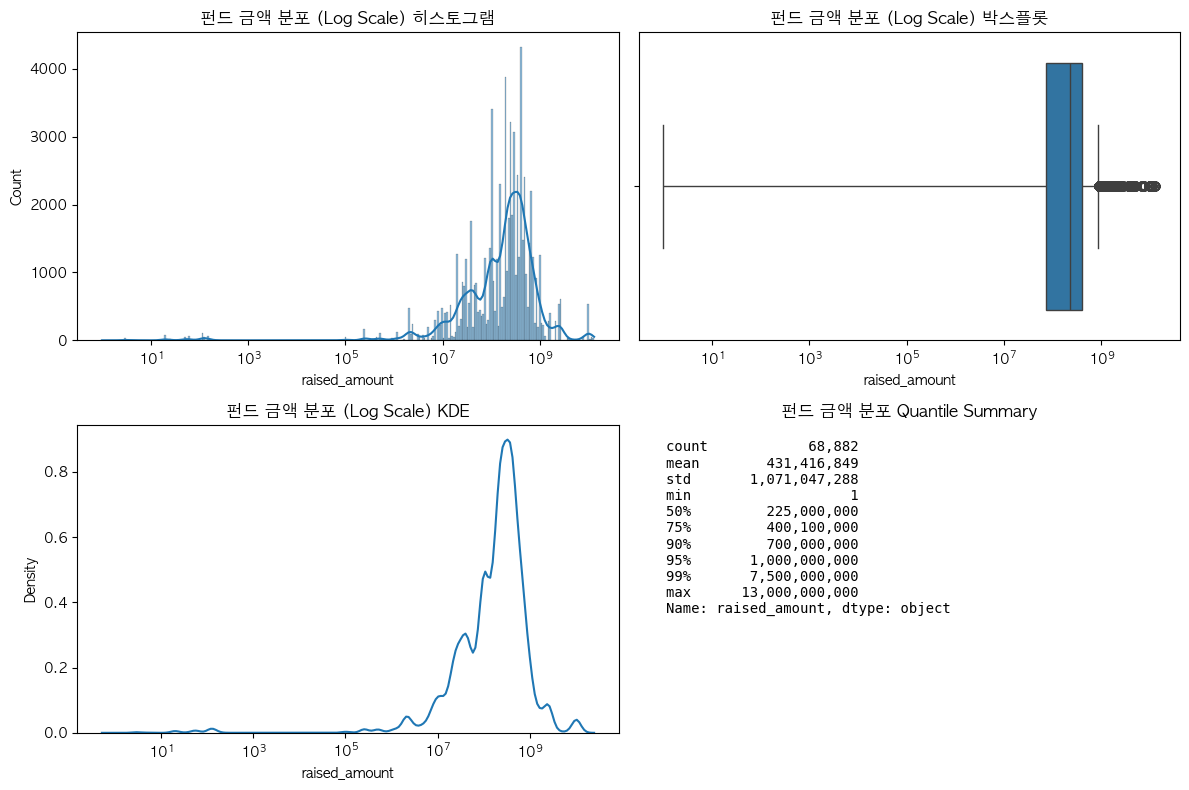

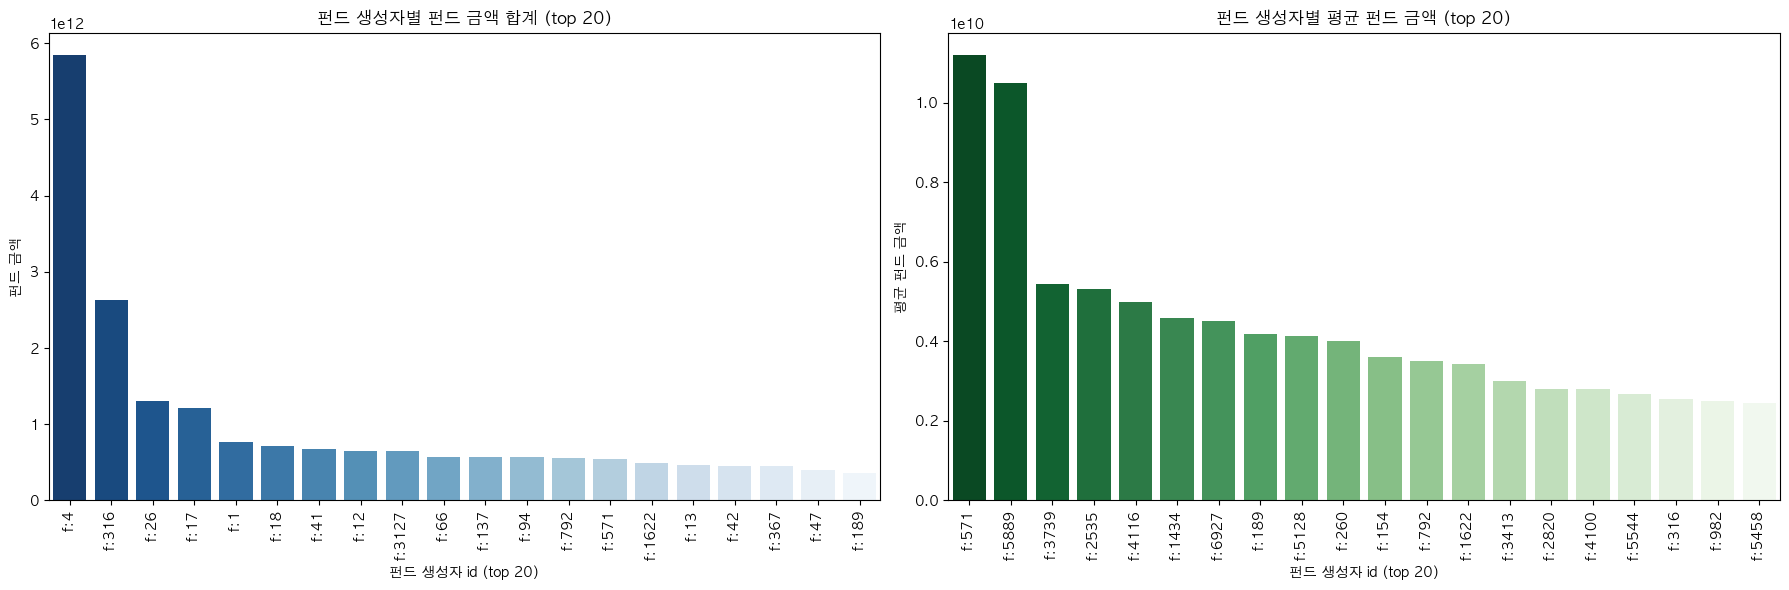

In [115]:
#########################
# 변경자: 수아
# 변경일자: 25.12.10
# 변경
# 내용: 1. 투자자 분석 EDA(VC 펀드 규모) + 시각화
#      2. 펀드 금액(raised_amount) 존재하는 행들만 가격 분포 분석 -> 공식 투자의 경우
#########################

# ============================================================
# VC의 펀드 조달 규모 분석(펀드 금액 공개된 경우 한정)
# ============================================================
# 공개 투자 변수 생성
open_fund = vc_fundraising[(vc_fundraising['raised_amount'].notna())&(vc_fundraising['raised_amount']!=0)]
# 기초 통계
open_fund.describe()

# 공개 투자 기준 투자자 id와 펀드 생성자 id 동일 여부 확인
open_fund[open_fund['investor_cfp_id']==open_fund['funds_f_id']]

# 공개 투자는 모두 공식 투자이다.(fund_id 모두 존자)
open_fund[open_fund['fund_id'].isna()]

def amount(open_fund):
    fig, axes = plt.subplots(2,2, figsize=(12,8))
    # 로그 스케일 히스토그램
    sns.histplot(data=open_fund, x='raised_amount', log_scale=True, kde=True, ax=axes[0,0])
    axes[0,0].set_title("펀드 금액 분포 (Log Scale) 히스토그램")
    
    # 로그 스케일 박스플롯
    sns.boxplot(x=open_fund['raised_amount'], ax=axes[0,1])
    axes[0,1].set_xscale('log')
    axes[0,1].set_title("펀드 금액 분포 (Log Scale) 박스플롯")
    
    # 로그 스케일 kde/밀도 곡선
    sns.kdeplot(open_fund['raised_amount'], log_scale=True, ax=axes[1,0])
    axes[1,0].set_title("펀드 금액 분포 (Log Scale) KDE")

    # Qauntile Summary
    summary = open_fund['raised_amount'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
    summary = summary.apply(lambda x: f"{x:,.0f}")
    axes[1,1].axis('off')  # 그래프 대신 텍스트 출력 영역 비움
    axes[1,1].text(0.05, 0.95, str(summary), fontsize=10, verticalalignment='top', family='monospace')
    axes[1,1].set_title("펀드 금액 분포 Quantile Summary")

    plt.tight_layout()
    plt.show()

    return summary

result = amount(open_fund)


# ============================================================
# 펀드 생성자(투자자)별 펀드 금액 분포
# ============================================================
# Top 20 펀드 생성자 (합계 기준)
top20_sum = open_fund.groupby("funds_f_id")['raised_amount'].sum().sort_values(ascending=False).head(20)
top20_mean = open_fund.groupby("funds_f_id")['raised_amount'].mean().sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# (1) 합계
sns.barplot(x=top20_sum.index, y=top20_sum.values, palette='Blues_r', ax=axes[0])
axes[0].set_xlabel("펀드 생성자 id (top 20)")
axes[0].set_ylabel("펀드 금액")
axes[0].set_title("펀드 생성자별 펀드 금액 합계 (top 20)")
axes[0].tick_params(axis='x', rotation=90)

# (2) 평균
sns.barplot(x=top20_mean.index, y=top20_mean.values, palette='Greens_r', ax=axes[1])
axes[1].set_xlabel("펀드 생성자 id (top 20)")
axes[1].set_ylabel("평균 펀드 금액")
axes[1].set_title("펀드 생성자별 평균 펀드 금액 (top 20)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

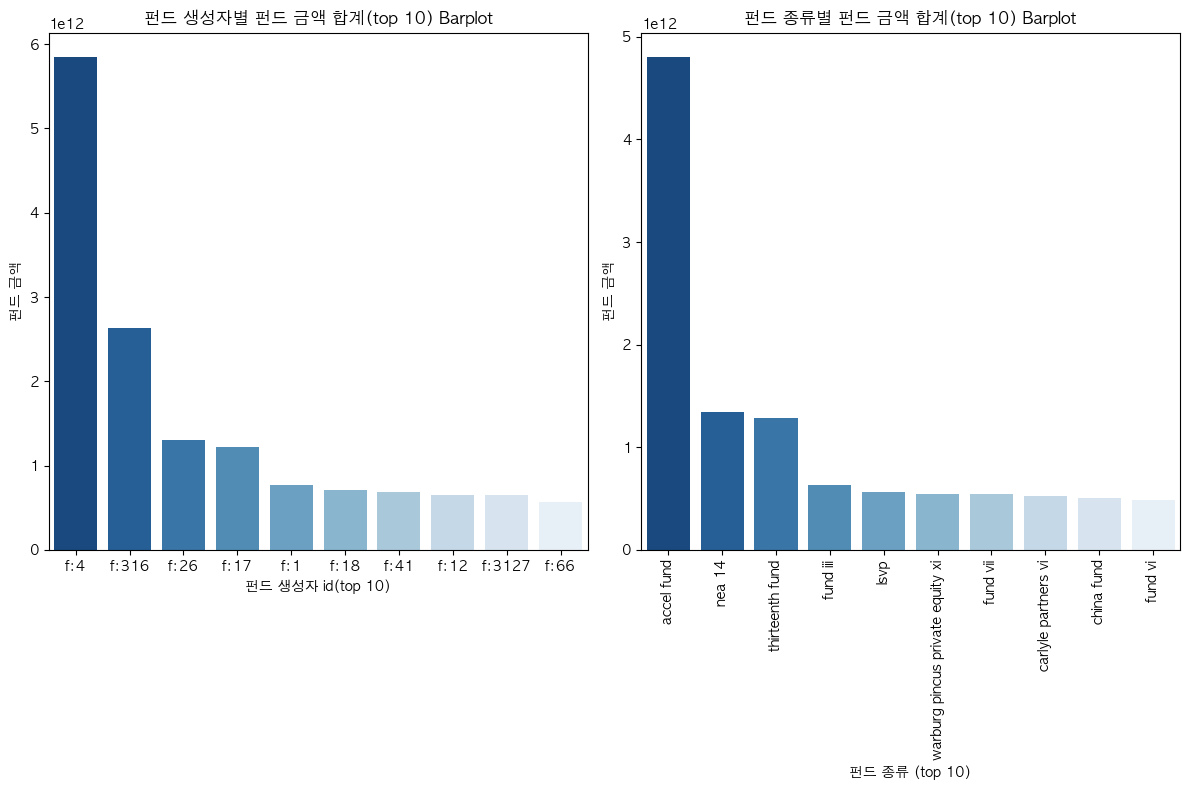

In [116]:
# ============================================================
# 펀드 생성자(투자자), 펀드 종류별 펀드 금액 분포
# ============================================================
# 펀드 생성자별, 펀드별, 펀드 종류별 펀드 금액 분포
top10_FO = (open_fund.groupby("funds_f_id")['raised_amount'].sum().sort_values(ascending=False).head(10).reset_index())
top10_fund_name = (open_fund.groupby("cat_funds_name")['raised_amount'].sum().sort_values(ascending=False).head(10).reset_index())

def open_f(top10_FO,top10_fund_name):
    fig, axes = plt.subplots(1,2, figsize=(12,8))
    
    # barplot 펀드 생성자별 펀드 금액 합계 분포
    sns.barplot(data=top10_FO, x='funds_f_id', y='raised_amount', palette='Blues_r', ax=axes[0])
    axes[0].set_xlabel("펀드 생성자 id(top 10)")
    axes[0].set_ylabel("펀드 금액")
    axes[0].set_title("펀드 생성자별 펀드 금액 합계(top 10) Barplot")
    
    # barplot 펀드 종류별 펀드 금액 합계 분포
    sns.barplot(data=top10_fund_name, x='cat_funds_name', y='raised_amount', palette='Blues_r', ax=axes[1])
    axes[1].set_xlabel("펀드 종류 (top 10)")
    axes[1].set_ylabel("펀드 금액")
    axes[1].tick_params(axis="x", rotation=90)
    axes[1].set_title("펀드 종류별 펀드 금액 합계(top 10) Barplot")
    
    plt.tight_layout()
    plt.show()

open_f(top10_FO,top10_fund_name)


In [ ]:
# 공개 펀드 중 펀드 조성금 상위 20개 펀드
open_fund.groupby(["funds_f_id", "cat_funds_name", 'fund_id'])['raised_amount'].sum().sort_values(ascending=False).head(20).reset_index()

funds_f_id                    cat_funds_name  fund_id  raised_amount
0         f:4                        accel fund     97.0   4.800000e+12
1       f:316                            nea 14    869.0   1.339000e+12
2       f:316                   thirteenth fund    166.0   1.287500e+12
3        f:94                              lsvp    883.0   5.640000e+11
4       f:571  warburg pincus private equity xi   1135.0   5.488000e+11
5       f:792               carlyle partners vi   1458.0   5.200000e+11
6        f:17                        china fund    151.0   5.070000e+11
7      f:1622                 venture fund 2012    740.0   4.800000e+11
8        f:42    bessemer venture partners viii    438.0   4.528000e+11
9         f:4              accel growth fund ii    485.0   4.200000e+11
10     f:3127                          fund iii    584.0   3.675000e+11
11       f:17                global growth fund    975.0   3.549000e+11
12      f:189                         apax viii   1210.0   3.225000e+11
13       f:26                       dfj fund ix   1631.0   3.187800e+11
14       f:41                          fund xiv    351.0   3.107000e+11
15        f:1                 greylock fund xiv     99.0   3.070000e+11
16        f:1                greylock fund xiii    420.0   3.070000e+11
17       f:26                          fund vii   1633.0   3.049200e+11
18       f:86       norwest venture partners xi    115.0   2.628000e+11
19       f:66                khosla ventures iv    466.0   2.562000e+11

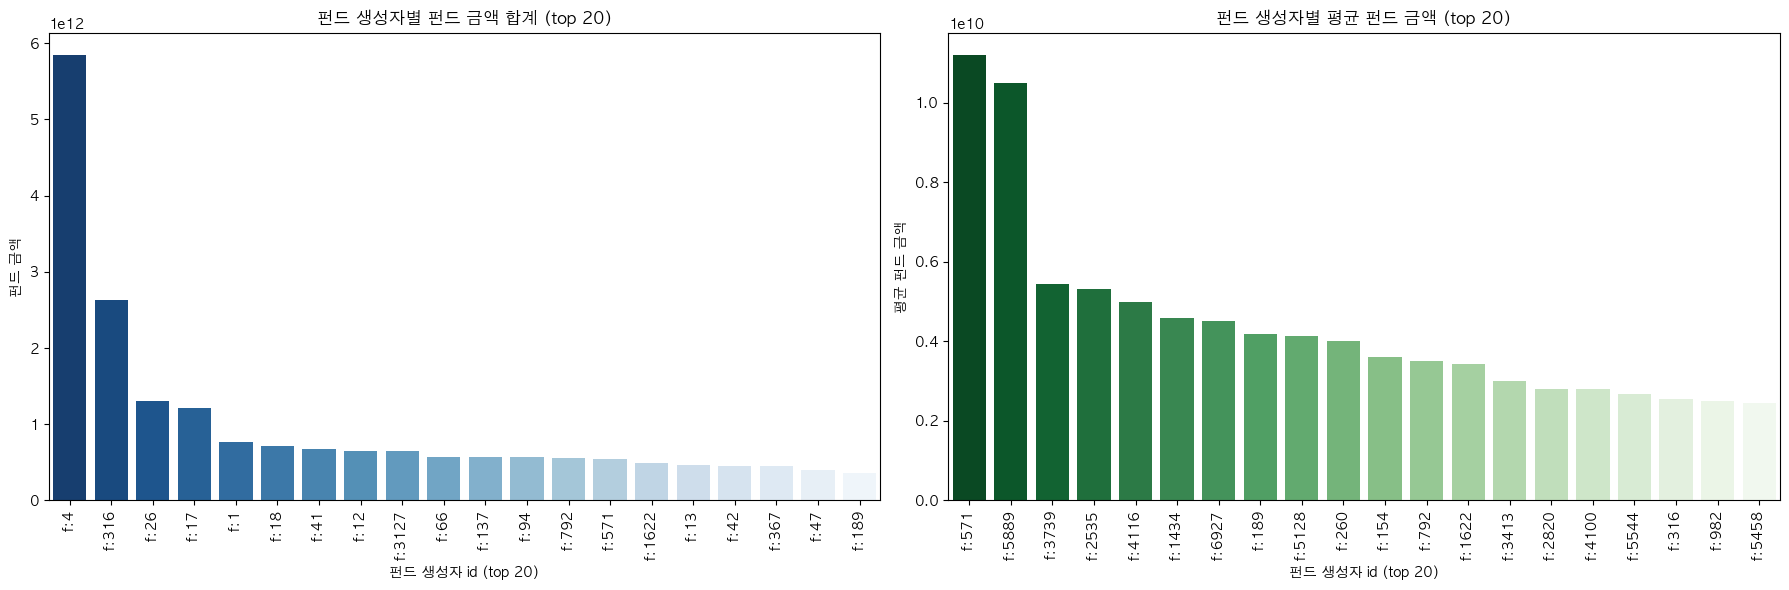

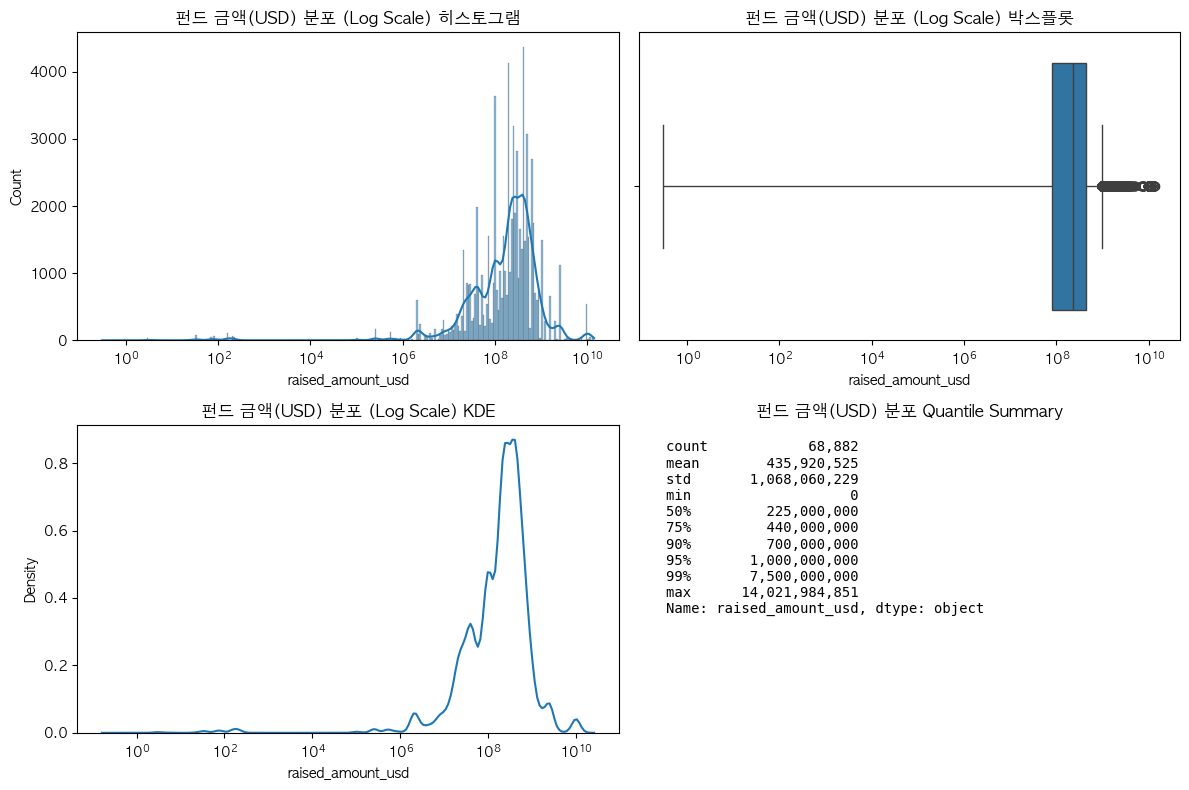

In [120]:
#########################
# 변경자: 수아
# 변경일자: 25.12.11
# 변경
# 내용: 1. 투자자 분석 EDA(VC 펀드 규모) + 시각화(USD 금액 통일)
#      2. 펀드 금액(raised_amount_usd) 존재하는 행들만 가격 분포 분석 -> 공식 투자의 경우
#########################

# ============================================================
# VC의 펀드 조달 규모 분석(펀드 금액 공개된 경우 한정)
# ============================================================
# 공개 투자 변수 생성
open_fund_usd = vc_fundraising[vc_fundraising['raised_amount_usd'].notna()]
# 기초 통계
open_fund_usd.describe()

def amount(open_fund_usd):
    fig, axes = plt.subplots(2,2, figsize=(12,8))
    # 로그 스케일 히스토그램
    sns.histplot(data=open_fund_usd, x='raised_amount_usd', log_scale=True, kde=True, ax=axes[0,0])
    axes[0,0].set_title("펀드 금액(USD) 분포 (Log Scale) 히스토그램")
    
    # 로그 스케일 박스플롯
    sns.boxplot(x=open_fund_usd['raised_amount_usd'], ax=axes[0,1])
    axes[0,1].set_xscale('log')
    axes[0,1].set_title("펀드 금액(USD) 분포 (Log Scale) 박스플롯")
    
    # 로그 스케일 kde/밀도 곡선
    sns.kdeplot(open_fund_usd['raised_amount_usd'], log_scale=True, ax=axes[1,0])
    axes[1,0].set_title("펀드 금액(USD) 분포 (Log Scale) KDE")

    # Qauntile Summary
    summary = open_fund_usd['raised_amount_usd'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
    summary = summary.apply(lambda x: f"{x:,.0f}")
    axes[1,1].axis('off')  # 그래프 대신 텍스트 출력 영역 비움
    axes[1,1].text(0.05, 0.95, str(summary), fontsize=10, verticalalignment='top', family='monospace')
    axes[1,1].set_title("펀드 금액(USD) 분포 Quantile Summary")

    plt.tight_layout()
    plt.show()

    return summary

# ============================================================
# 펀드 생성자(투자자)별 펀드 금액 분포
# ============================================================
# Top 20 펀드 생성자 (합계 기준)
top20_sum = open_fund.groupby("funds_f_id")['raised_amount'].sum().sort_values(ascending=False).head(20)
top20_mean = open_fund.groupby("funds_f_id")['raised_amount'].mean().sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# (1) 합계
sns.barplot(x=top20_sum.index, y=top20_sum.values, palette='Blues_r', ax=axes[0])
axes[0].set_xlabel("펀드 생성자 id (top 20)")
axes[0].set_ylabel("펀드 금액")
axes[0].set_title("펀드 생성자별 펀드 금액 합계 (top 20)")
axes[0].tick_params(axis='x', rotation=90)

# (2) 평균
sns.barplot(x=top20_mean.index, y=top20_mean.values, palette='Greens_r', ax=axes[1])
axes[1].set_xlabel("펀드 생성자 id (top 20)")
axes[1].set_ylabel("평균 펀드 금액")
axes[1].set_title("펀드 생성자별 평균 펀드 금액 (top 20)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

result = amount(open_fund_usd)

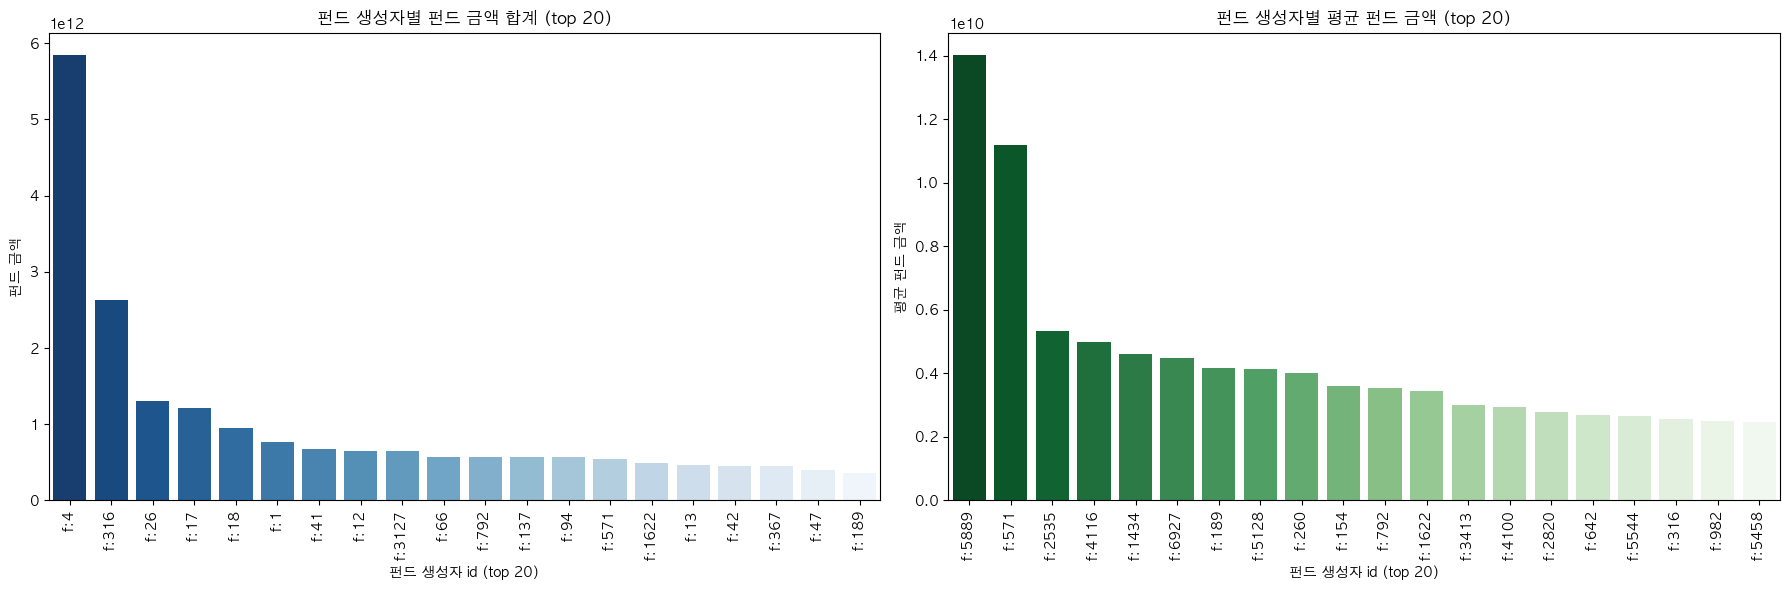

In [121]:
# ============================================================
# 펀드 생성자(투자자)별 펀드 금액 분포
# ============================================================
# Top 20 펀드 생성자 (합계 기준)
top20_sum = open_fund.groupby("funds_f_id")['raised_amount_usd'].sum().sort_values(ascending=False).head(20)
top20_mean = open_fund.groupby("funds_f_id")['raised_amount_usd'].mean().sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# (1) 합계
sns.barplot(x=top20_sum.index, y=top20_sum.values, palette='Blues_r', ax=axes[0])
axes[0].set_xlabel("펀드 생성자 id (top 20)")
axes[0].set_ylabel("펀드 금액")
axes[0].set_title("펀드 생성자별 펀드 금액 합계 (top 20)")
axes[0].tick_params(axis='x', rotation=90)

# (2) 평균
sns.barplot(x=top20_mean.index, y=top20_mean.values, palette='Greens_r', ax=axes[1])
axes[1].set_xlabel("펀드 생성자 id (top 20)")
axes[1].set_ylabel("평균 펀드 금액")
axes[1].set_title("펀드 생성자별 평균 펀드 금액 (top 20)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


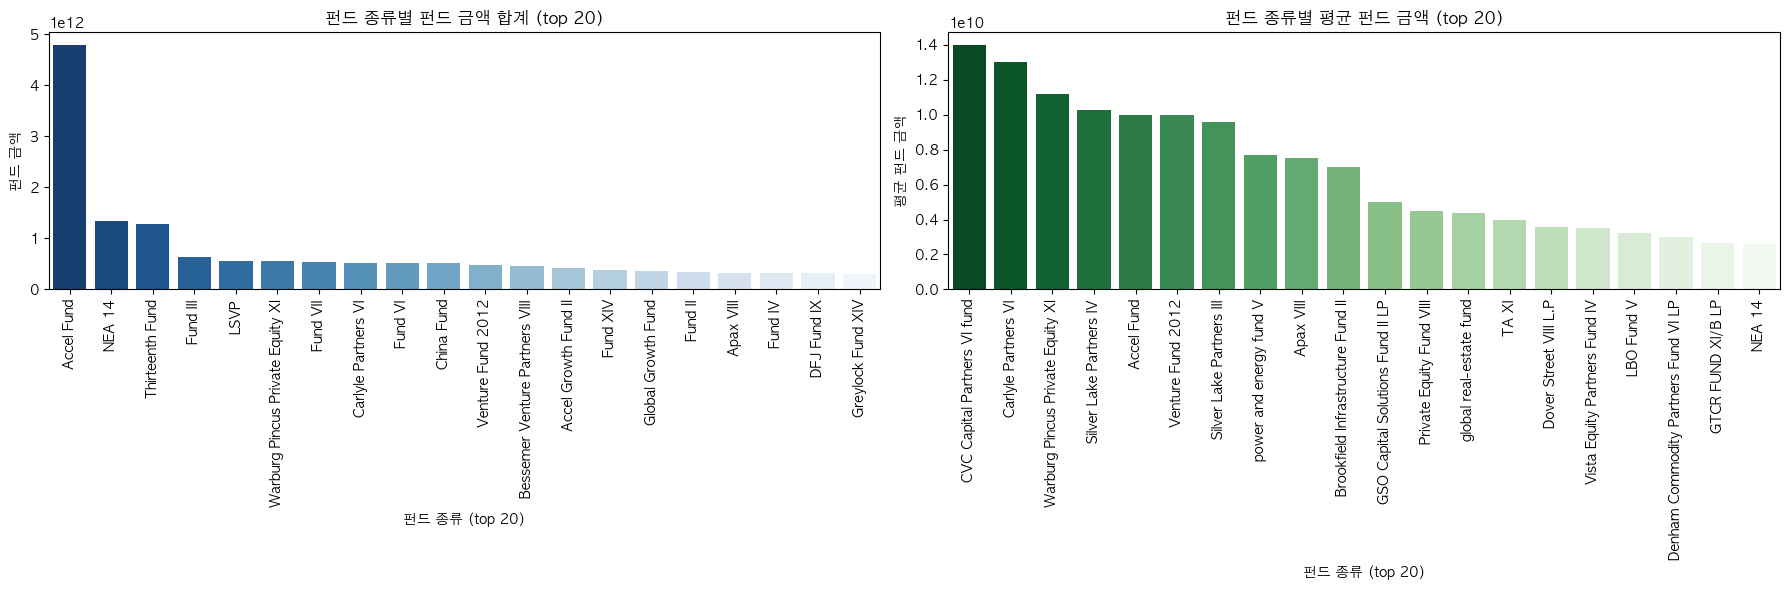

In [123]:
# ============================================================
# 펀드 종류별 펀드 금액 분포
# ============================================================
# Top 20 펀드 종류 (합계 기준)
top20_sum = open_fund.groupby("name")['raised_amount_usd'].sum().sort_values(ascending=False).head(20)
top20_mean = open_fund.groupby("name")['raised_amount_usd'].mean().sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# (1) 합계
sns.barplot(x=top20_sum.index, y=top20_sum.values, palette='Blues_r', ax=axes[0])
axes[0].set_xlabel("펀드 종류 (top 20)")
axes[0].set_ylabel("펀드 금액")
axes[0].set_title("펀드 종류별 펀드 금액 합계 (top 20)")
axes[0].tick_params(axis='x', rotation=90)

# (2) 평균
sns.barplot(x=top20_mean.index, y=top20_mean.values, palette='Greens_r', ax=axes[1])
axes[1].set_xlabel("펀드 종류 (top 20)")
axes[1].set_ylabel("평균 펀드 금액")
axes[1].set_title("펀드 종류별 평균 펀드 금액 (top 20)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


### VC의 투자 패턴

In [124]:
#########################
# 변경자: 수아
# 변경일자: 25.12.11
# 변경
# 내용: 1. 투자자 - VC의 투자 패턴 분석(투자 산업)
#      2. vc_invest_cat_fr 
#########################
# 회사 설립일(운영 기간): funded_at

# 투자 유치 경험: is_first_round, is_last_round, first_funding_at, last_funding_at, funding_rounds(지금까지 받은 투자 라운드 수), funding_total_usd(총 투자 금액)
# 기업 관련 소식: milestones(소식 개수)
# 기업 규모: relationships(직원 수?), is_past(끝난 관계인지 여부: 1(과거)), sequence(우선순위?), cat_rel_title(직책)
# 회사의 위치: country_code, state_code/obj_state_filled, city, cat_obj_region
# 타 회사에 투자해본 경험? : investment_rounds, invested_companies


# investor_cfp_id: FinancialOrg 필터링
FO_invest_cat_fr = vc_invest_cat_fr[vc_invest_cat_fr['investor_cfp_id'].str.startswith('f:')]

In [125]:
FO_invest_cat_fr

investments_id  funding_round_id invested_c_id investor_cfp_id  \
0                   1                 1           c:4             f:1   
1                   2                 1           c:4             f:2   
2                   3                 3           c:5             f:4   
3                   4                 4           c:5             f:1   
4                   5                 4           c:5             f:5   
...               ...               ...           ...             ...   
61398           61399             57926       c:15847           f:173   
61399           61400             57926       c:15847          f:1290   
61400           61401             57926       c:15847            f:73   
61401           61402             57942       c:70841         f:15098   
61402           61403             57948      c:211890          f:2101   

        fr_c_id  funded_at funding_round_type funding_round_code  \
0           c:4 2006-12-01           series-b                  b   
1           c:4 2006-12-01           series-b                  b   
2           c:5        NaT           series-a                  a   
3           c:5        NaT           series-b                  b   
4           c:5        NaT           series-b                  b   
...         ...        ...                ...                ...   
61398   c:15847 2013-12-12            venture       unattributed   
61399   c:15847 2013-12-12            venture       unattributed   
61400   c:15847 2013-12-12            venture       unattributed   
61401   c:70841 2013-12-12            venture       unattributed   
61402  c:211890 2013-12-12           series-a                  a   

       raised_amount_usd  pre_money_valuation_usd  post_money_valuation_usd  \
0              8500000.0                      NaN                       NaN   
1              8500000.0                      NaN                       NaN   
2             12700000.0              115000000.0                       NaN   
3             27500000.0              525000000.0                       NaN   
4             27500000.0              525000000.0                       NaN   
...                  ...                      ...                       ...   
61398         15000000.0                      NaN                       NaN   
61399         15000000.0                      NaN                       NaN   
61400         15000000.0                      NaN                       NaN   
61401                NaN                      NaN                       NaN   
61402          3000000.0                      NaN                       NaN   

       participants  is_first_round  is_last_round  funded_year  \
0                 2               0              0       2006.0   
1                 2               0              0       2006.0   
2                 3               0              0          NaN   
3                 4               0              0          NaN   
4                 4               0              0          NaN   
...             ...             ...            ...          ...   
61398             4               1              0       2013.0   
61399             4               1              0       2013.0   
61400             4               1              0       2013.0   
61401             1               1              1       2013.0   
61402             1               1              1       2013.0   

      funded_quarter cat_fr_type  num_fr_type  log_participants  \
0             2006Q4    series-b            3          1.098612   
1             2006Q4    series-b            3          1.098612   
2                NaT    series-a            2          1.386294   
3                NaT    series-b            3          1.609438   
4                NaT    series-b            3          1.609438   
...              ...         ...          ...               ...   
61398         2013Q4     venture            1          1.609438   
61399         2013Q4   

##### 산업별 VC의 투자 패턴

In [127]:
# 산업별 VC의 투자 건수
FO_invest_cat_fr['category_code'].value_counts()

category_code
software            9028
biotech             7395
enterprise          4429
mobile              4335
web                 4055
advertising         3162
cleantech           2632
ecommerce           2610
games_video         2165
hardware            2163
semiconductor       2039
analytics           1754
medical             1715
network_hosting     1317
security            1150
finance              975
public_relations     813
social               790
education            731
health               632
other                623
search               561
manufacturing        482
fashion              470
messaging            436
hospitality          377
consulting           349
news                 344
travel               335
music                289
nanotech             246
photo_video          232
real_estate          200
transportation       170
automotive           164
nonprofit             96
sports                95
design                79
legal                 74
pets       

In [128]:
# 회사 산업(overview)별 VC의 투자 횟수
FO_invest_cat_fr['cat_obj_overview'].value_counts()

cat_obj_overview
Software & Technology    55536
Media & Content           1518
Social & Community        1470
Health & Wellness         1083
Marketing & AdTech         533
E-commerce & Retail        452
Finance & FinTech          301
Gaming & Virtual           132
Education & Training       101
Professional Services       21
Name: count, dtype: int64

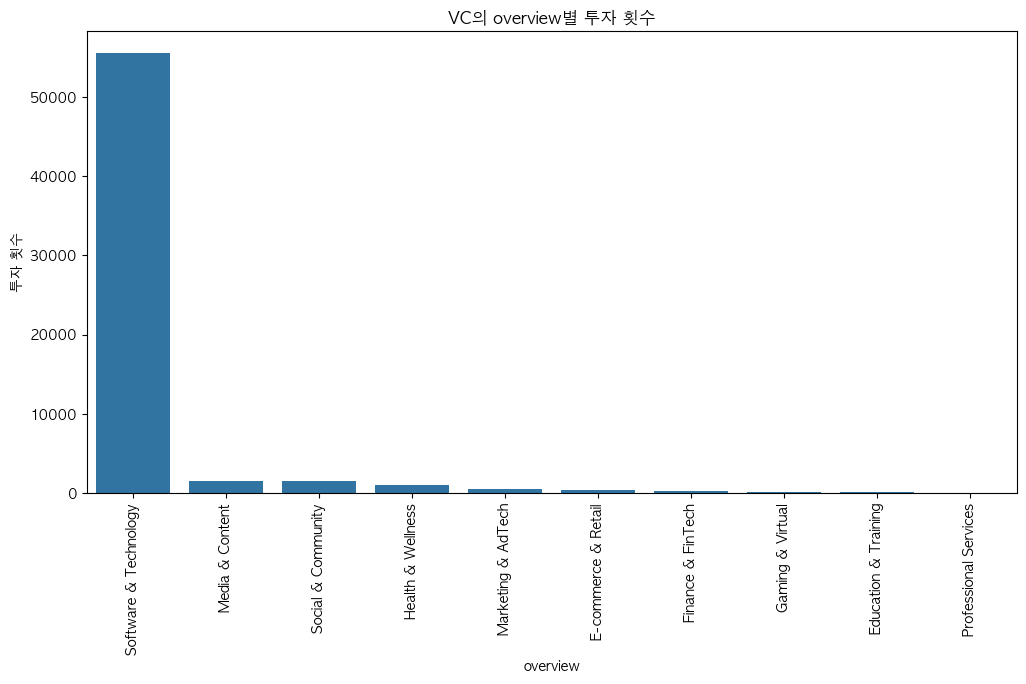

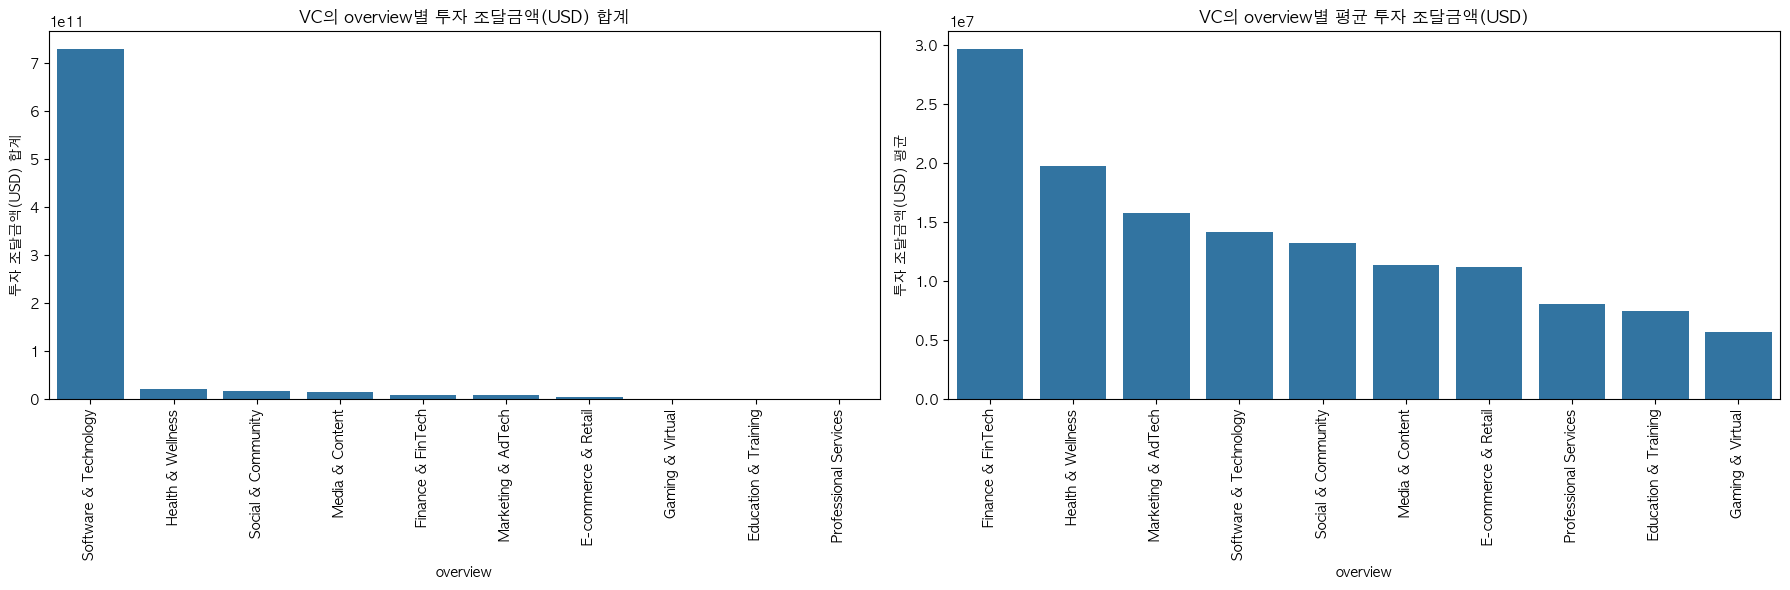

In [129]:
# overview별 VC의 투자 횟수
order = FO_invest_cat_fr['cat_obj_overview'].value_counts().index # 내림차순 정렬 순서

plt.figure(figsize=(12,6))
sns.countplot(data=FO_invest_cat_fr, x='cat_obj_overview', order=order)
plt.xlabel("overview")
plt.ylabel("투자 횟수")
plt.title("VC의 overview별 투자 횟수")
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

# 투자 조달금 정보 공개 필터
open_cat_amount = FO_invest_cat_fr[FO_invest_cat_fr['is_fr_raised_private']==0]

# 산업별 투자 조달금 합계와 평균 계산 + 정렬
cat_sum_sorted = (
    open_cat_amount.groupby('cat_obj_overview')['raised_amount_usd']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

cat_mean_sorted = (
    open_cat_amount.groupby('cat_obj_overview')['raised_amount_usd']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# 서브플롯으로 합계와 평균 한 번에 보기
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# (1) 합계
sns.barplot(
    data=cat_sum_sorted,
    x='cat_obj_overview',
    y='raised_amount_usd',
    errorbar=None,
    ax=axes[0]
)
axes[0].set_xlabel('overview')
axes[0].set_ylabel('투자 조달금액(USD) 합계')
axes[0].set_title("VC의 overview별 투자 조달금액(USD) 합계")
axes[0].tick_params(axis='x', rotation=90)

# (2) 평균
sns.barplot(
    data=cat_mean_sorted,
    x='cat_obj_overview',
    y='raised_amount_usd',
    errorbar=None,
    ax=axes[1]
)
axes[1].set_xlabel('overview')
axes[1].set_ylabel('투자 조달금액(USD) 평균')
axes[1].set_title("VC의 overview별 평균 투자 조달금액(USD)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

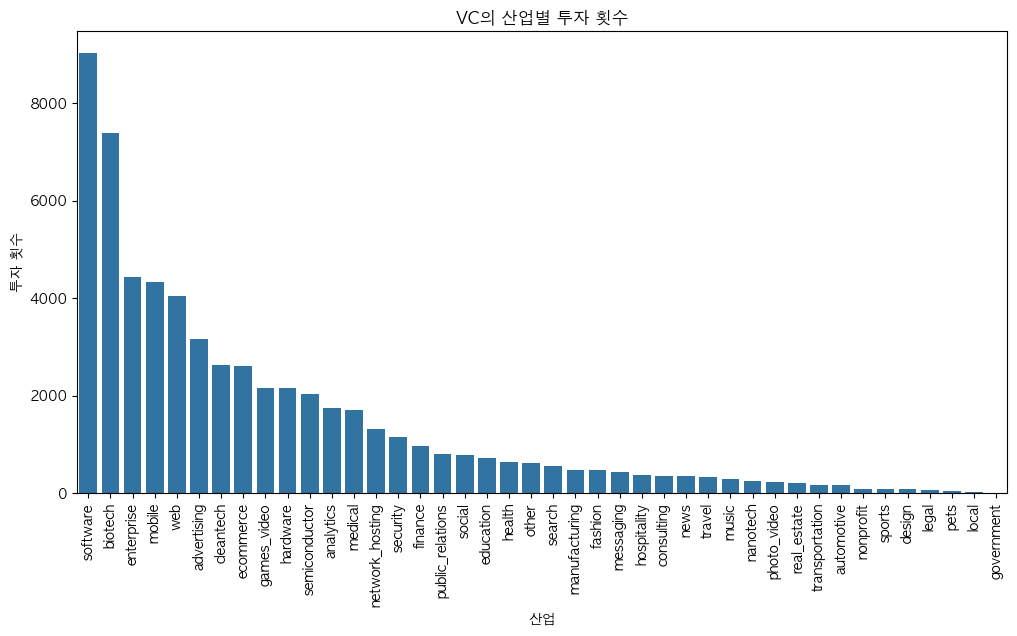

In [130]:
# 산업별 VC의 투자 횟수
order = FO_invest_cat_fr['category_code'].value_counts().index # 내림차순 정렬 순서

plt.figure(figsize=(12,6))
sns.countplot(data=FO_invest_cat_fr, x='category_code', order=order)
plt.xlabel("산업")
plt.ylabel("투자 횟수")
plt.title("VC의 산업별 투자 횟수")
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

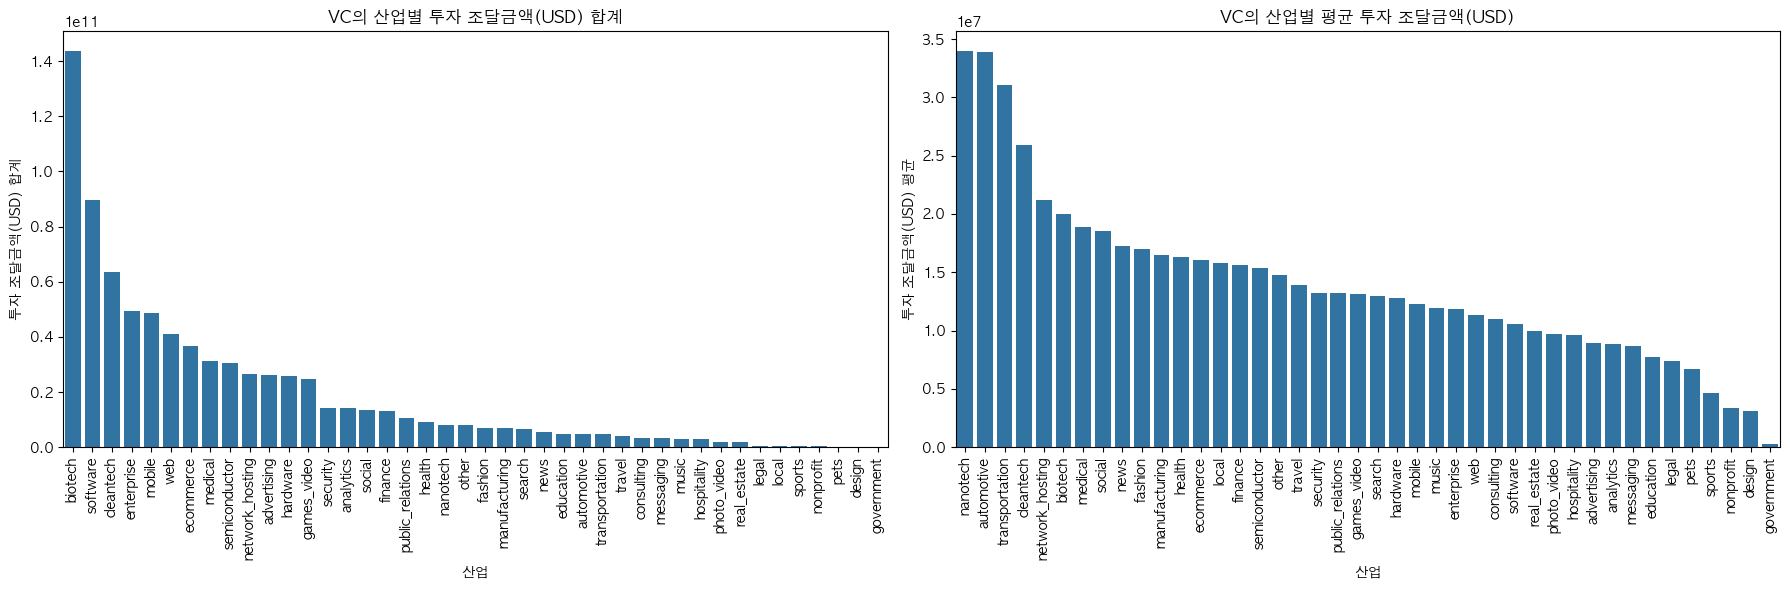

In [132]:
# 투자 조달금 정보 공개 필터
open_cat_amount = FO_invest_cat_fr[FO_invest_cat_fr['is_fr_raised_private']==0]

# 산업별 투자 조달금 합계와 평균 계산 + 정렬
cat_sum_sorted = (
    open_cat_amount.groupby('category_code')['raised_amount_usd']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

cat_mean_sorted = (
    open_cat_amount.groupby('category_code')['raised_amount_usd']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# 서브플롯으로 합계와 평균 한 번에 보기
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# (1) 합계
sns.barplot(
    data=cat_sum_sorted,
    x='category_code',
    y='raised_amount_usd',
    errorbar=None,
    ax=axes[0]
)
axes[0].set_xlabel('산업')
axes[0].set_ylabel('투자 조달금액(USD) 합계')
axes[0].set_title("VC의 산업별 투자 조달금액(USD) 합계")
axes[0].tick_params(axis='x', rotation=90)

# (2) 평균
sns.barplot(
    data=cat_mean_sorted,
    x='category_code',
    y='raised_amount_usd',
    errorbar=None,
    ax=axes[1]
)
axes[1].set_xlabel('산업')
axes[1].set_ylabel('투자 조달금액(USD) 평균')
axes[1].set_title("VC의 산업별 평균 투자 조달금액(USD)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

##### 스타트업 투자라운드별 VC 투자패턴

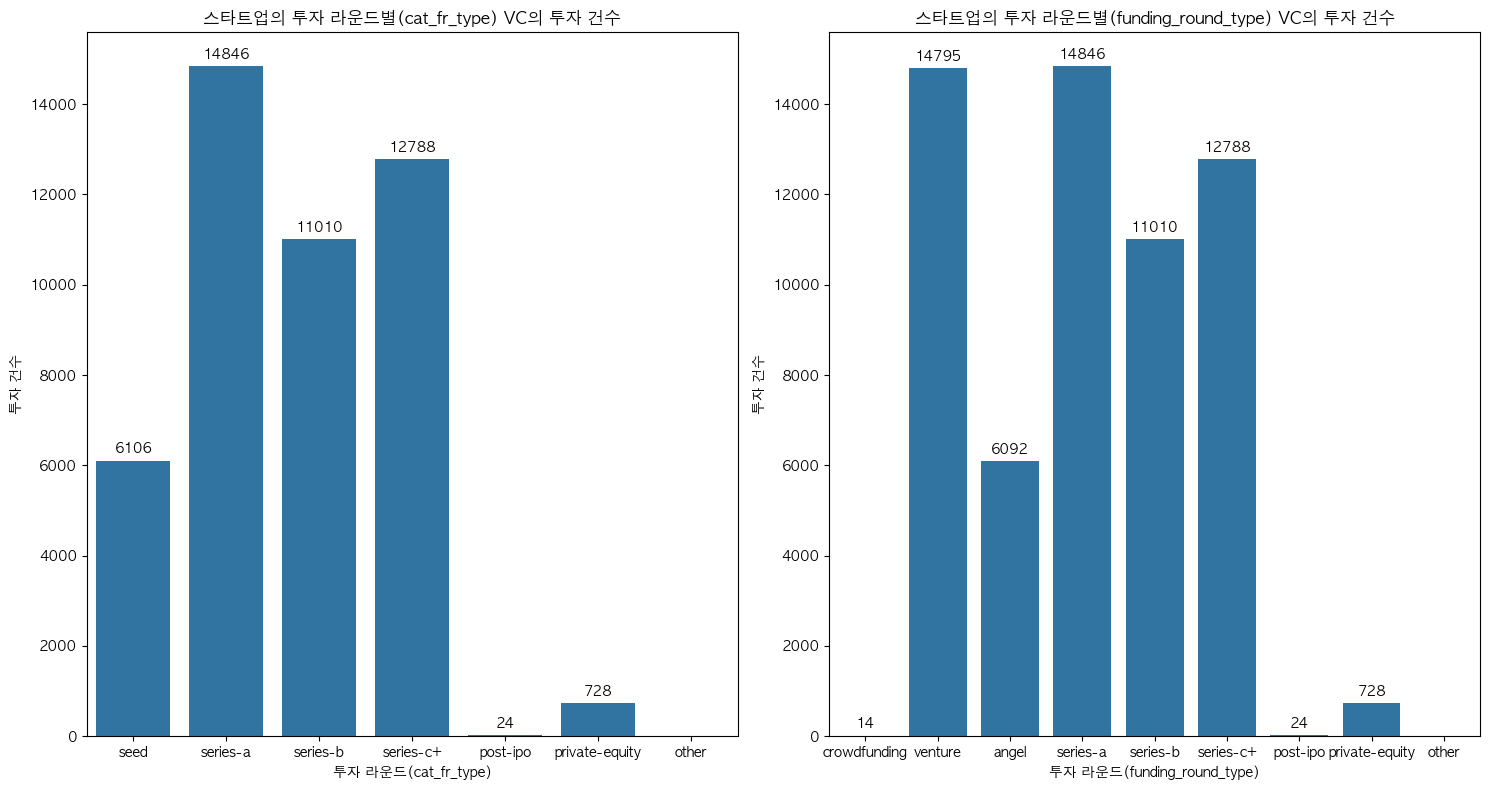

In [133]:
# ==================================
# 스타트업 투자 라운드별 VC의 투자 건수
# ==================================

fig, axes = plt.subplots(1,2, figsize=(15,8))

# 스타트업 투자 라운드(cat_fr_type)별 VC의 투자 건수
fr_order = ['seed', 'series-a', 'series-b', 'series-c+', 'post-ipo', 'private-equity', 'other'] # 막대 순서

ax = sns.countplot(data=FO_invest_cat_fr, x='cat_fr_type', order=fr_order, ax=axes[0])
axes[0].set_title("스타트업의 투자 라운드별(cat_fr_type) VC의 투자 건수")
axes[0].set_xlabel("투자 라운드(cat_fr_type)")
axes[0].set_ylabel("투자 건수")

for container in ax.containers:
    axes[0].bar_label(container, padding=3)

# 스타트업 투자 라운드별(funding_round_type) VC의 투자 건수
fr_order_1 = ['crowdfunding', 'venture', 'angel', 'series-a', 'series-b', 'series-c+', 'post-ipo', 'private-equity', 'other'] # 막대 순서

ap = sns.countplot(data=FO_invest_cat_fr, x='funding_round_type', order=fr_order_1, ax=axes[1])
axes[1].set_title("스타트업의 투자 라운드별(funding_round_type) VC의 투자 건수")
axes[1].set_xlabel("투자 라운드(funding_round_type)")
axes[1].set_ylabel("투자 건수")
for container in ap.containers:
    axes[1].bar_label(container, padding=3)
    
plt.tight_layout()
plt.show()


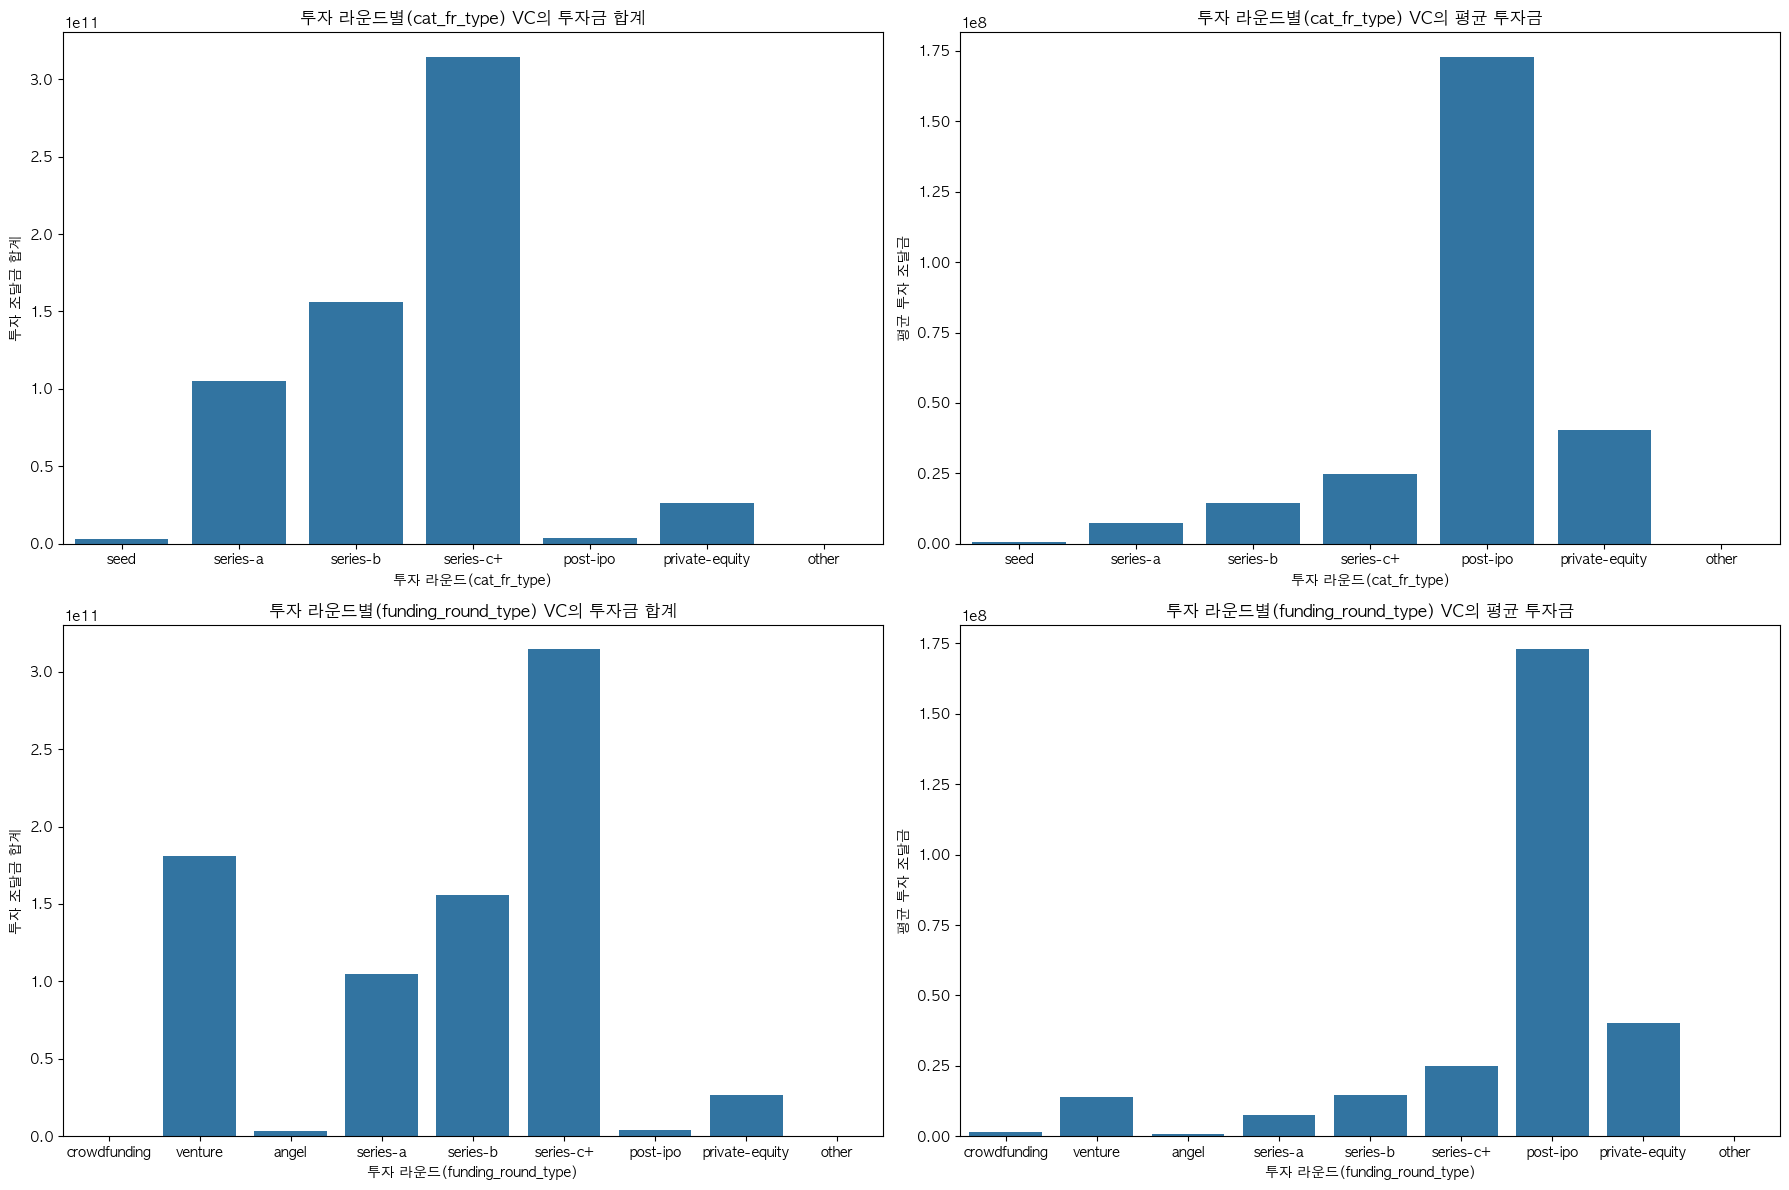

In [134]:
# ==================================
# 스타트업 투자 라운드별 VC의 투자 조달금 분포
# ==================================
open_cat_amount = FO_invest_cat_fr[FO_invest_cat_fr['is_fr_raised_private']==0]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# ============ cat_fr_type ============
# (1) cat_fr_type - 합계
sns.barplot(data=open_cat_amount, x='cat_fr_type', y='raised_amount_usd', 
            order=fr_order, estimator=sum, errorbar=None, ax=axes[0, 0])
axes[0, 0].set_title("투자 라운드별(cat_fr_type) VC의 투자금 합계")
axes[0, 0].set_xlabel("투자 라운드(cat_fr_type)")
axes[0, 0].set_ylabel("투자 조달금 합계")

# (2) cat_fr_type - 평균
sns.barplot(data=open_cat_amount, x='cat_fr_type', y='raised_amount_usd', 
            order=fr_order, errorbar=None, ax=axes[0, 1])
axes[0, 1].set_title("투자 라운드별(cat_fr_type) VC의 평균 투자금")
axes[0, 1].set_xlabel("투자 라운드(cat_fr_type)")
axes[0, 1].set_ylabel("평균 투자 조달금")

# ============ funding_round_type ============
# (3) funding_round_type - 합계
sns.barplot(data=open_cat_amount, x='funding_round_type', y='raised_amount_usd', 
            order=fr_order_1, estimator=sum, errorbar=None, ax=axes[1, 0])
axes[1, 0].set_title("투자 라운드별(funding_round_type) VC의 투자금 합계")
axes[1, 0].set_xlabel("투자 라운드(funding_round_type)")
axes[1, 0].set_ylabel("투자 조달금 합계")

# (4) funding_round_type - 평균
sns.barplot(data=open_cat_amount, x='funding_round_type', y='raised_amount_usd', 
            order=fr_order_1, errorbar=None, ax=axes[1, 1])
axes[1, 1].set_title("투자 라운드별(funding_round_type) VC의 평균 투자금")
axes[1, 1].set_xlabel("투자 라운드(funding_round_type)")
axes[1, 1].set_ylabel("평균 투자 조달금")

plt.tight_layout()
plt.show()

##### 참여 투자자 수에 따른 VC의 투자 패턴

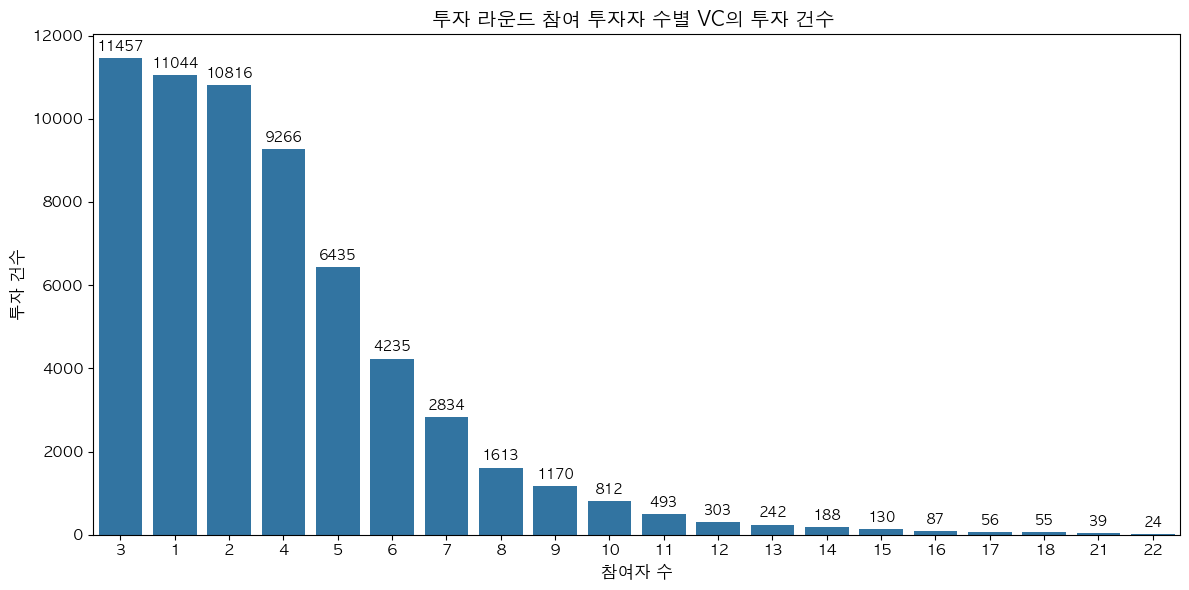

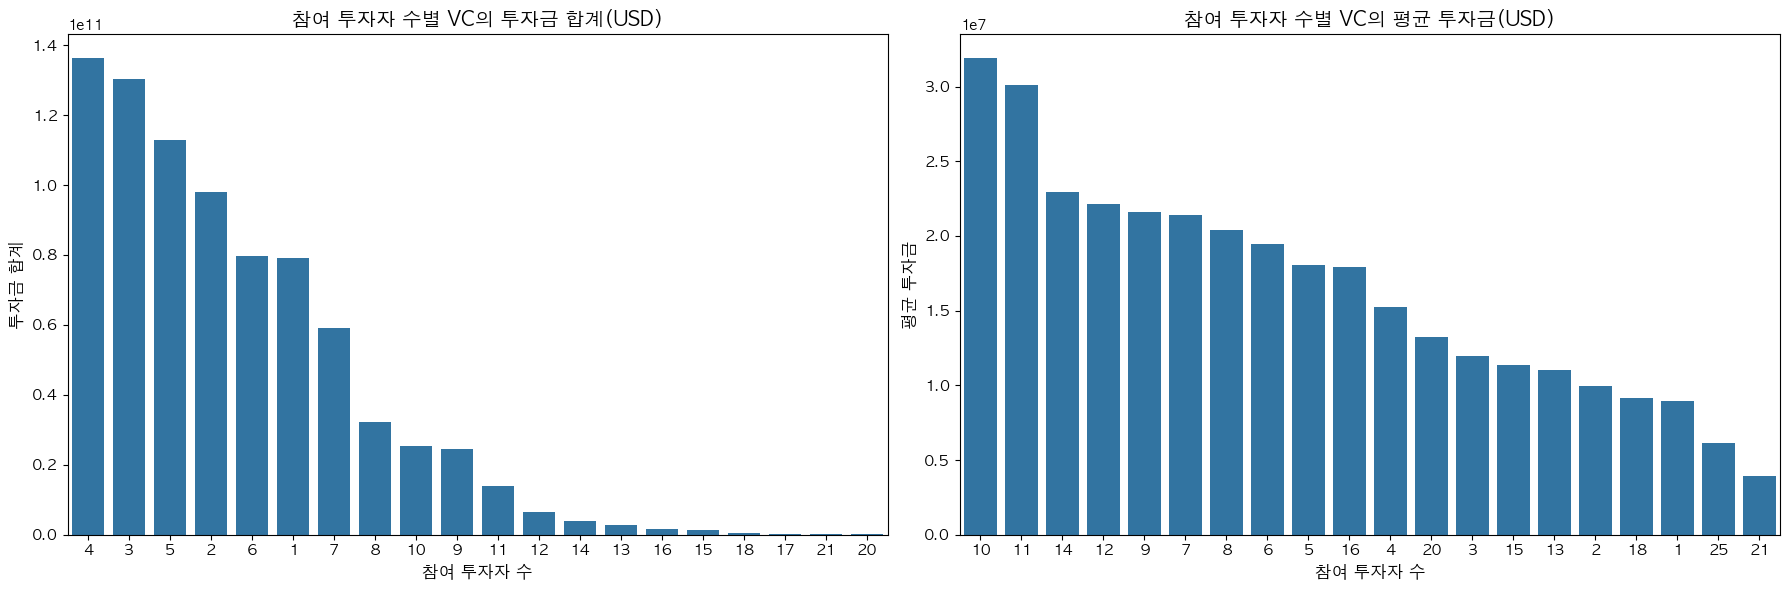

In [135]:
# =====================================
# 투자 라운드 참여자 수별 VC 투자 패턴
# =====================================
FO_invest_cat_fr = vc_invest_cat_fr[vc_invest_cat_fr['investor_cfp_id'].str.startswith('f:')]
open_cat_amount = FO_invest_cat_fr[FO_invest_cat_fr['is_fr_raised_private']==0]

# 데이터 정렬 (상위 20개)
participants_cnt_sorted = FO_invest_cat_fr['participants'].value_counts(ascending=False).head(20)
participants_sum_sorted = open_cat_amount.groupby('participants')['raised_amount_usd'].sum().sort_values(ascending=False).head(20)
participants_mean_sorted = open_cat_amount.groupby('participants')['raised_amount_usd'].mean().sort_values(ascending=False).head(20)

# (1) 투자 건수 - 개별 그래프
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=FO_invest_cat_fr, x='participants', order=participants_cnt_sorted.index)
plt.title("투자 라운드 참여 투자자 수별 VC의 투자 건수 ", fontsize=14)
plt.xlabel("참여자 수", fontsize=12)
plt.ylabel("투자 건수", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# 막대에 숫자 표시
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.tight_layout()
plt.show()

# (2) 투자금 합계와 평균 - 함께
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 합계
sns.barplot(
    data=open_cat_amount,
    x='participants',
    y='raised_amount_usd',
    order=participants_sum_sorted.index,
    estimator=sum,
    errorbar=None,
    ax=axes[0]
)
axes[0].set_title("참여 투자자 수별 VC의 투자금 합계(USD)", fontsize=14)
axes[0].set_xlabel("참여 투자자 수", fontsize=12)
axes[0].set_ylabel("투자금 합계", fontsize=12)
axes[0].tick_params(axis='both', labelsize=11)

# 평균
sns.barplot(
    data=open_cat_amount,
    x='participants',
    y='raised_amount_usd',
    order=participants_mean_sorted.index,
    errorbar=None,
    ax=axes[1]
)
axes[1].set_title("참여 투자자 수별 VC의 평균 투자금(USD)", fontsize=14)
axes[1].set_xlabel("참여 투자자 수", fontsize=12)
axes[1].set_ylabel("평균 투자금", fontsize=12)
axes[1].tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.show()

In [ ]:
# VC의 투자 참여자 수 빈도 내림차순 정렬
FO_invest_cat_fr['participants'].value_counts(ascending=False)

participants
3     11457
1     11044
2     10816
4      9266
5      6435
6      4235
7      2834
8      1613
9      1170
10      812
11      493
12      303
13      242
14      188
15      130
16       87
17       56
18       55
21       39
22       24
23       16
25       14
28       13
19       12
32       10
26        9
20        8
27        8
29        6
36        4
24        4
Name: count, dtype: int64

##### VC는 어떤 창업자에게 투자할까?

In [165]:
vc_invest_founder

investments_id  funding_round_id invested_c_id investor_cfp_id  \
0                    1                 1           c:4             f:1   
1                    1                 1           c:4             f:1   
2                    1                 1           c:4             f:1   
3                    1                 1           c:4             f:1   
4                    1                 1           c:4             f:1   
...                ...               ...           ...             ...   
959666           80900             57929      c:286183           p:365   
959667           80901             57929      c:286183        p:176466   
959668           80901             57929      c:286183        p:176466   
959669           80902             57929      c:286183        p:268577   
959670           80902             57929      c:286183        p:268577   

         fr_c_id  funded_at funding_round_type funding_round_code  \
0            c:4 2006-12-01           series-b                  b   
1            c:4 2006-12-01           series-b                  b   
2            c:4 2006-12-01           series-b                  b   
3            c:4 2006-12-01           series-b                  b   
4            c:4 2006-12-01           series-b                  b   
...          ...        ...                ...                ...   
959666  c:286183 2013-12-12              angel               seed   
959667  c:286183 2013-12-12              angel               seed   
959668  c:286183 2013-12-12              angel               seed   
959669  c:286183 2013-12-12              angel               seed   
959670  c:286183 2013-12-12              angel               seed   

        raised_amount_usd  pre_money_valuation_usd  post_money_valuation_usd  \
0               8500000.0                      NaN                       NaN   
1               8500000.0                      NaN                       NaN   
2               8500000.0                      NaN                       NaN   
3               8500000.0                      NaN                       NaN   
4               8500000.0                      NaN                       NaN   
...                   ...                      ...                       ...   
959666           225000.0                      NaN                       NaN   
959667           225000.0                      NaN                       NaN   
959668           225000.0                      NaN                       NaN   
959669           225000.0                      NaN                       NaN   
959670           225000.0                      NaN                       NaN   

        participants  is_first_round  is_last_round  funded_year  \
0                  2               0              0       2006.0   
1                  2               0              0       2006.0   
2                  2               0              0       2006.0   
3                  2               0              0       2006.0   
4                  2               0              0       2006.0   
...              ...             ...            ...          ...   
959666             3               1              1       2013.0   
959667             3               1              1       2013.0   
959668             3               1              1       2013.0   
959669             3               1              1       2013.0   
959670             3               1              1       2013.0   

       funded_quarter cat_fr_type  num_fr_type  log_participants  \
0              2006Q4    series-b            3          1.098612   
1              2006Q4    series-b            3          1.098612   
2              2006Q4    series-b            3          1.098612   
3              2006Q4    series-b            3          1.098612   
4              2006Q4    series-b            3          1.098612   
...               ...         ...          ...               ...   
959666         2013Q4        seed   

In [139]:
# VC 데이터 필터링
# investor_cfp_id: FinancialOrg
FO_invest_founder = vc_invest_founder[vc_invest_founder['investor_cfp_id'].str.startswith('f:')]

# raised_amount_usd 공개 투자금 필터
open_founder_amount = FO_invest_founder[FO_invest_founder['is_fr_raised_private']==0]

# 창업자 필터
founder_filtered = vc_invest_founder[vc_invest_founder['cat_rel_title']=='Founders']

In [140]:
founder_filtered

investments_id  funding_round_id invested_c_id investor_cfp_id  \
153                  3                 3           c:5             f:4   
215                  3                 3           c:5             f:4   
216                  3                 3           c:5             f:4   
286                  3                 3           c:5             f:4   
549                  4                 4           c:5             f:1   
...                ...               ...           ...             ...   
959645           80896             57880      c:285244        p:267312   
959650           80897             57882      c:285244         p:15712   
959651           80897             57882      c:285244         p:15712   
959656           80898             57882      c:285244        p:267312   
959657           80898             57882      c:285244        p:267312   

         fr_c_id funded_at funding_round_type funding_round_code  \
153          c:5       NaT           series-a                  a   
215          c:5       NaT           series-a                  a   
216          c:5       NaT           series-a                  a   
286          c:5       NaT           series-a                  a   
549          c:5       NaT           series-b                  b   
...          ...       ...                ...                ...   
959645  c:285244       NaT           series-a                  a   
959650  c:285244       NaT              angel              angel   
959651  c:285244       NaT              angel              angel   
959656  c:285244       NaT              angel              angel   
959657  c:285244       NaT              angel              angel   

        raised_amount_usd  pre_money_valuation_usd  post_money_valuation_usd  \
153            12700000.0              115000000.0                       NaN   
215            12700000.0              115000000.0                       NaN   
216            12700000.0              115000000.0                       NaN   
286            12700000.0              115000000.0                       NaN   
549            27500000.0              525000000.0                       NaN   
...                   ...                      ...                       ...   
959645                NaN                      NaN                       NaN   
959650                NaN                      NaN                       NaN   
959651                NaN                      NaN                       NaN   
959656                NaN                      NaN                       NaN   
959657                NaN                      NaN                       NaN   

        participants  is_first_round  is_last_round  funded_year  \
153                3               0              0          NaN   
215                3               0              0          NaN   
216                3               0              0          NaN   
286                3               0              0          NaN   
549                4               0              0          NaN   
...              ...             ...            ...          ...   
959645             3               0              0          NaN   
959650             3               0              1          NaN   
959651             3               0              1          NaN   
959656             3               0              1          NaN   
959657             3               0              1          NaN   

       funded_quarter cat_fr_type  num_fr_type  log_participants  \
153               NaT    series-a            2          1.386294   
215               NaT    series-a            2          1.386294   
216               NaT    series-a            2          1.386294   
286               NaT    series-a            2          1.386294   
549               NaT    series-b            3          1.609438   
...               ...         ...          ...               ...   
959645            NaT    series-a            2  

In [ ]:
# 창업자 데이터 중복 투자 값 제거(cat_degree_type은 최종 학력만 남기기로)

import numpy as np
import pandas as pd

# ================================
# 0. 원본 보호: 작업용 복사본 생성
# ================================

df = vc_invest_founder.copy()   # ← 원본 변경 없음!


# ================================
# 1. 최종학력 선택 함수
# ================================

degree_rank = {
    'Doctorate': 5,
    'Master’s degree': 4,
    'Bachelor’s degree': 3,
    'Associate degree': 2
}

def pick_highest_degree(series):
    # series가 리스트로 들어오는 경우 방지
    series = pd.Series(series)

    # NaN 제거
    series_no_nan = series.dropna()

    # 모두 NaN → Unknown
    if len(series_no_nan) == 0:
        return 'Unknown'

    # 정규 학력만 필터링
    regular = series_no_nan[series_no_nan.isin(degree_rank.keys())]

    # 1) 정규 학력이 있으면 그중 최고 학력 반환
    if len(regular) > 0:
        ranked = regular.map(degree_rank)
        return regular.iloc[ranked.argmax()]   # ← idxmax 오류 방지 (argmax 사용)

    # 2) Others만 존재
    if 'Others' in series_no_nan.values:
        return 'Others'

    # 3) 나머지는 Unknown
    return 'Unknown'



# ================================
# 2. VC 투자 + Founder 필터링 (원본 df는 건드리지 않음)
# ================================

FO_invest = df[df['investor_cfp_id'].str.startswith('f:')].copy()

founder_filtered = FO_invest[FO_invest['cat_rel_title'] == 'Founders'].copy()


# ================================
# 3. 투자 이벤트별 최종학력 계산
# ================================

final_degree = (
    founder_filtered
    .groupby('investments_id')['cat_degrees_degree_type']
    .apply(pick_highest_degree)
    .reset_index()
    .rename(columns={'cat_degrees_degree_type': 'final_degree'})
)


# ================================
# 4. 투자 이벤트 단위 중복 제거 (원본 보존)
# ================================

unique_founder_events = founder_filtered.drop_duplicates(
    subset=['investments_id']
).copy()


# ================================
# 5. 최종학력 merge
# ================================

unique_founder_events = unique_founder_events.merge(
    final_degree,
    on='investments_id',
    how='left'
)


In [ ]:
# 중복 투자 데이터를 제거한 창업자 데이터프레임 unique_founder_events 생성
# 창업자의 최종학력 컬럼인 final_degree 생성
unique_founder_events

investments_id  funding_round_id invested_c_id investor_cfp_id  \
0                   3                 3           c:5             f:4   
1                   4                 4           c:5             f:1   
2                   5                 4           c:5             f:5   
3                   6                 4           c:5             f:6   
4                   7                 4           c:5          f:3181   
...               ...               ...           ...             ...   
22794           61387             57877      c:181145          f:9913   
22795           61388             57879      c:285244         f:15039   
22796           61389             57879      c:285244          f:2019   
22797           61390             57880      c:285244         f:15039   
22798           61394             57903       c:10272           f:136   

        fr_c_id  funded_at funding_round_type funding_round_code  \
0           c:5        NaT           series-a                  a   
1           c:5        NaT           series-b                  b   
2           c:5        NaT           series-b                  b   
3           c:5        NaT           series-b                  b   
4           c:5        NaT           series-b                  b   
...         ...        ...                ...                ...   
22794  c:181145 2013-12-12           series-b                  b   
22795  c:285244        NaT           series-b                  b   
22796  c:285244        NaT           series-b                  b   
22797  c:285244        NaT           series-a                  a   
22798   c:10272 2013-12-12            venture       unattributed   

       raised_amount_usd  pre_money_valuation_usd  post_money_valuation_usd  \
0             12700000.0              115000000.0                       NaN   
1             27500000.0              525000000.0                       NaN   
2             27500000.0              525000000.0                       NaN   
3             27500000.0              525000000.0                       NaN   
4             27500000.0              525000000.0                       NaN   
...                  ...                      ...                       ...   
22794         25000000.0                      NaN                       NaN   
22795                NaN                      NaN                       NaN   
22796                NaN                      NaN                       NaN   
22797                NaN                      NaN                       NaN   
22798         30000000.0                      NaN                       NaN   

       participants  is_first_round  is_last_round  funded_year  \
0                 3               0              0          NaN   
1                 4               0              0          NaN   
2                 4               0              0          NaN   
3                 4               0              0          NaN   
4                 4               0              0          NaN   
...             ...             ...            ...          ...   
22794             3               1              0       2013.0   
22795             5               0              0          NaN   
22796             5               0              0          NaN   
22797             3               0              0          NaN   
22798             1               1              0       2013.0   

      funded_quarter cat_fr_type  num_fr_type  log_participants  \
0                NaT    series-a            2          1.386294   
1                NaT    series-b            3          1.609438   
2                NaT    series-b            3          1.609438   
3                NaT    series-b            3          1.609438   
4                NaT    series-b            3          1.609438   
...              ...         ...          ...               ...   
22794         2013Q4    series-b            3          1.386294   
22795            NaT   

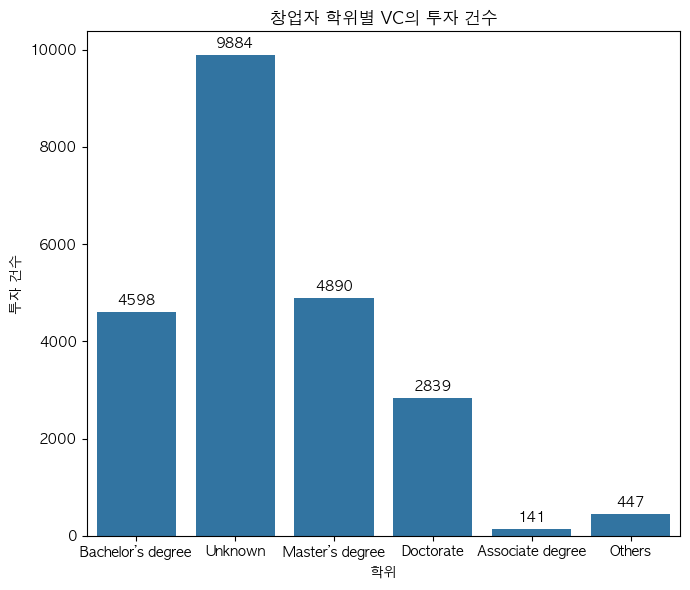

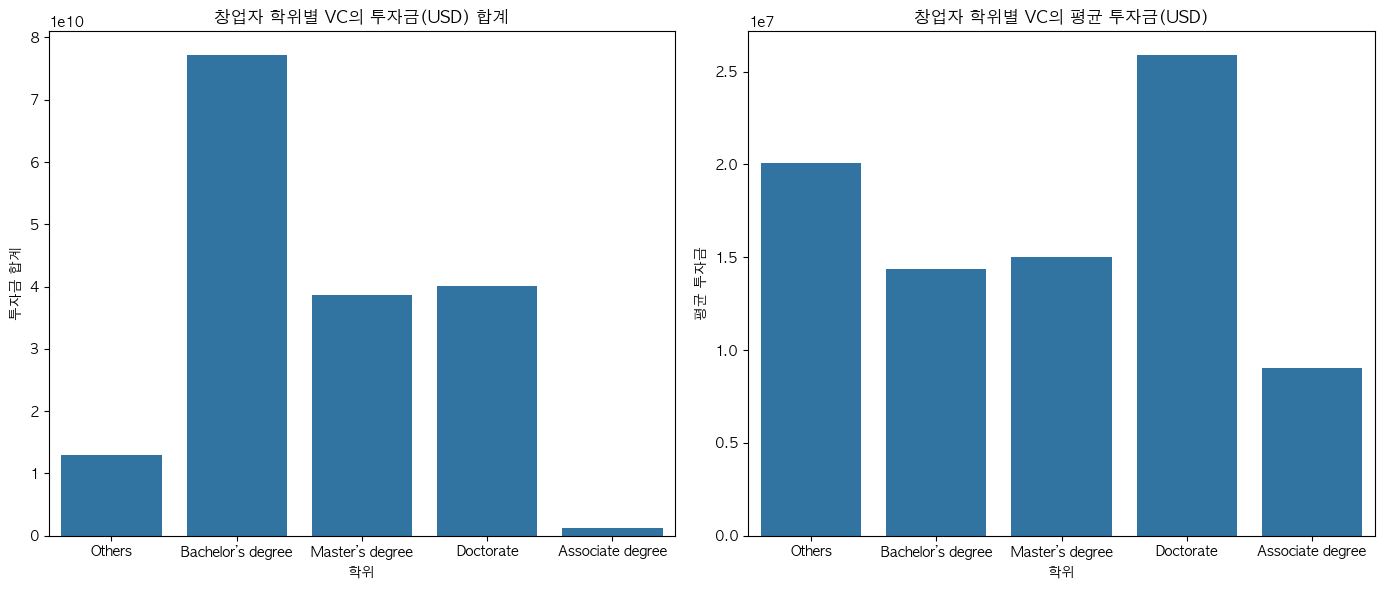

In [ ]:
# =====================================
# VC는 주로 어떤 학력을 가진 창업자에게 투자할까?
# =====================================
# cat_degrees_degree_type(학위) -> final_degree(최종학력)


# 공개된 투자금만 필터링
open_unique_founder_amount = unique_founder_events[
    unique_founder_events['is_fr_raised_private'] == 0
]

# 창업자 학위별 VC의 투자 건수
plt.figure(figsize=(7,6))
ax = sns.countplot(data=unique_founder_events, x='final_degree')
plt.title("창업자 학위별 VC의 투자 건수")
plt.xlabel("학위")
plt.ylabel("투자 건수")
for container in ax.containers:
    ax.bar_label(container, padding=3)
plt.tight_layout()
plt.show()

# 창업자 학위별 투자금액 - 합계와 평균
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# (1) 합계
sns.barplot(data=open_unique_founder_amount, x='cat_degrees_degree_type', y='raised_amount_usd', 
            estimator=sum, errorbar=None, ax=axes[0])
axes[0].set_title("창업자 학위별 VC의 투자금(USD) 합계")
axes[0].set_xlabel("학위")
axes[0].set_ylabel("투자금 합계")

# (2) 평균
sns.barplot(data=open_unique_founder_amount, x='cat_degrees_degree_type', y='raised_amount_usd', 
            errorbar=None, ax=axes[1])
axes[1].set_title("창업자 학위별 VC의 평균 투자금(USD)")
axes[1].set_xlabel("학위")
axes[1].set_ylabel("평균 투자금")

plt.tight_layout()
plt.show()

In [153]:
# institution(학교) -> 학교 순위 혹은 학교 위치
unique_founder_events['institution_normalized'].value_counts(ascending=False)

institution_normalized
stanford university                                              982
harvard university                                               557
california, berkeley university                                  358
massachusetts institute of technology (mit)                      337
columbia university                                              240
                                                                ... 
tehnièeski universitet varna                                       1
bath university                                                    1
koblenz, germany university                                        1
ecole nationale supérieure des télécommunications de bretagne      1
universidad privada boliviana                                      1
Name: count, Length: 774, dtype: int64

In [155]:
unique_founder_events

investments_id  funding_round_id invested_c_id investor_cfp_id  \
0                   3                 3           c:5             f:4   
1                   4                 4           c:5             f:1   
2                   5                 4           c:5             f:5   
3                   6                 4           c:5             f:6   
4                   7                 4           c:5          f:3181   
...               ...               ...           ...             ...   
22794           61387             57877      c:181145          f:9913   
22795           61388             57879      c:285244         f:15039   
22796           61389             57879      c:285244          f:2019   
22797           61390             57880      c:285244         f:15039   
22798           61394             57903       c:10272           f:136   

        fr_c_id  funded_at funding_round_type funding_round_code  \
0           c:5        NaT           series-a                  a   
1           c:5        NaT           series-b                  b   
2           c:5        NaT           series-b                  b   
3           c:5        NaT           series-b                  b   
4           c:5        NaT           series-b                  b   
...         ...        ...                ...                ...   
22794  c:181145 2013-12-12           series-b                  b   
22795  c:285244        NaT           series-b                  b   
22796  c:285244        NaT           series-b                  b   
22797  c:285244        NaT           series-a                  a   
22798   c:10272 2013-12-12            venture       unattributed   

       raised_amount_usd  pre_money_valuation_usd  post_money_valuation_usd  \
0             12700000.0              115000000.0                       NaN   
1             27500000.0              525000000.0                       NaN   
2             27500000.0              525000000.0                       NaN   
3             27500000.0              525000000.0                       NaN   
4             27500000.0              525000000.0                       NaN   
...                  ...                      ...                       ...   
22794         25000000.0                      NaN                       NaN   
22795                NaN                      NaN                       NaN   
22796                NaN                      NaN                       NaN   
22797                NaN                      NaN                       NaN   
22798         30000000.0                      NaN                       NaN   

       participants  is_first_round  is_last_round  funded_year  \
0                 3               0              0          NaN   
1                 4               0              0          NaN   
2                 4               0              0          NaN   
3                 4               0              0          NaN   
4                 4               0              0          NaN   
...             ...             ...            ...          ...   
22794             3               1              0       2013.0   
22795             5               0              0          NaN   
22796             5               0              0          NaN   
22797             3               0              0          NaN   
22798             1               1              0       2013.0   

      funded_quarter cat_fr_type  num_fr_type  log_participants  \
0                NaT    series-a            2          1.386294   
1                NaT    series-b            3          1.609438   
2                NaT    series-b            3          1.609438   
3                NaT    series-b            3          1.609438   
4                NaT    series-b            3          1.609438   
...              ...         ...          ...               ...   
22794         2013Q4    series-b            3          1.386294   
22795            NaT   

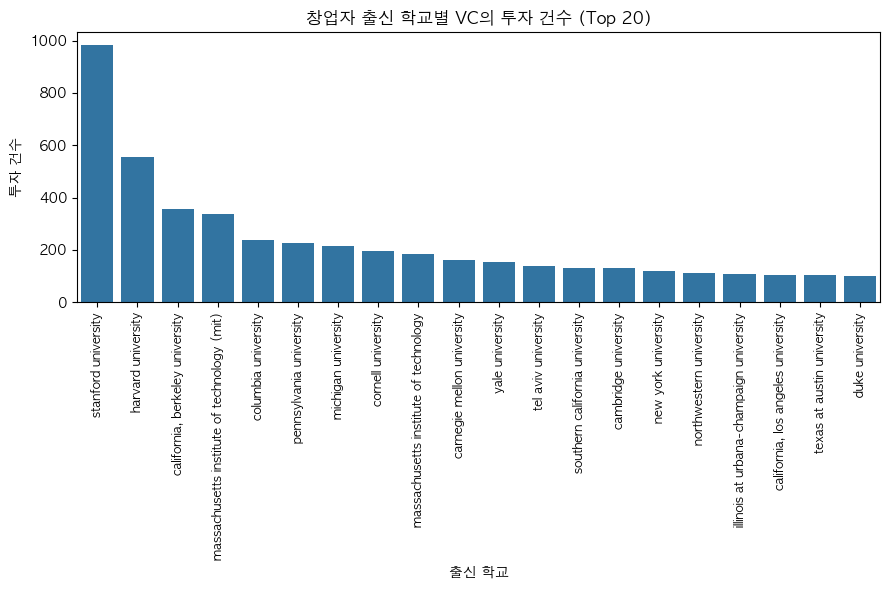

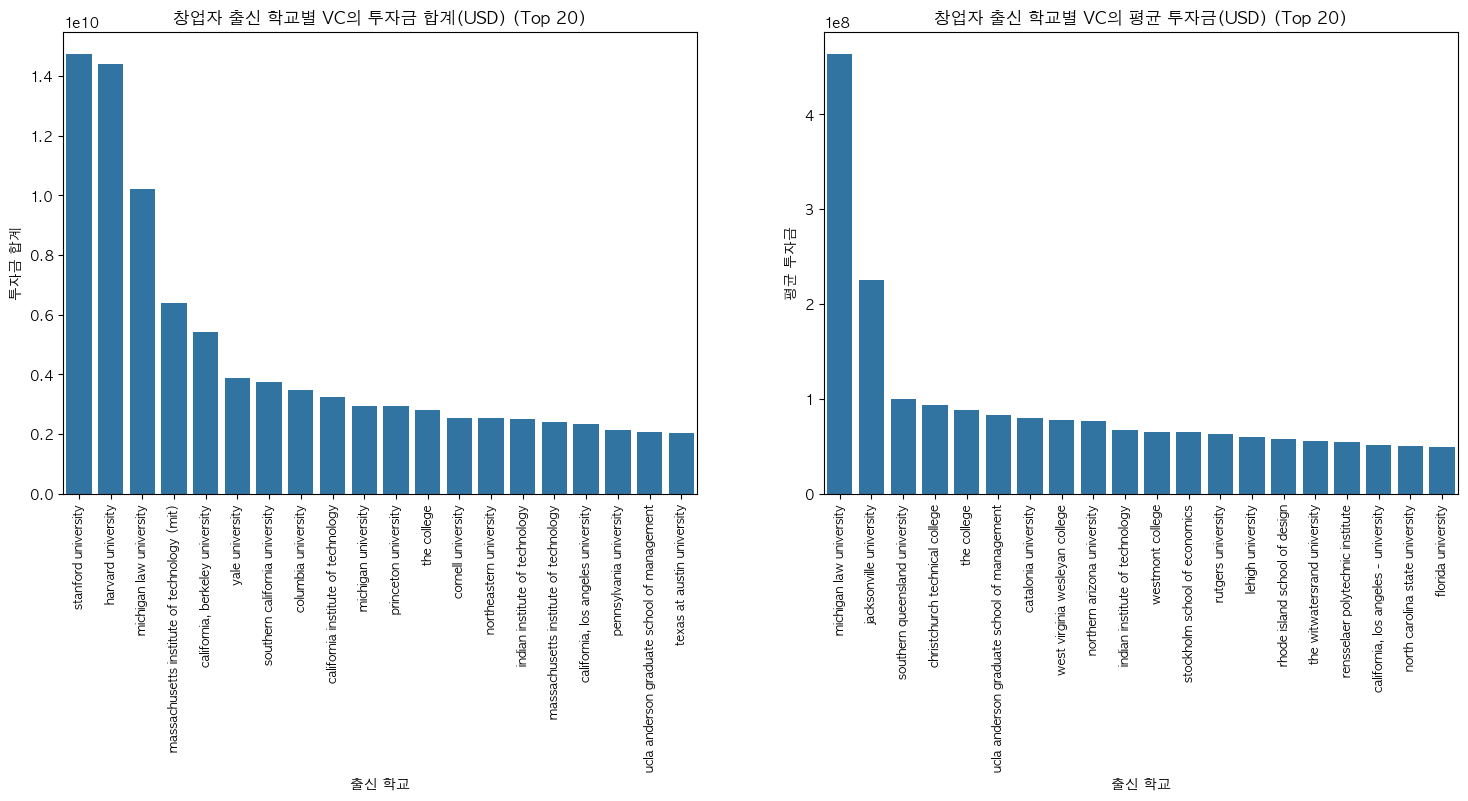

In [157]:
# 창업자 출신 학교별 VC의 투자 패턴
# 학교: institution

# 데이터 정렬
univ_cnt_sorted = unique_founder_events['institution_normalized'].value_counts(ascending=False).head(20)
univ_amount_sum_sorted = open_unique_founder_amount.groupby('institution_normalized')['raised_amount_usd'].sum().sort_values(ascending=False).head(20)
univ_amount_mean_sorted = open_unique_founder_amount.groupby('institution_normalized')['raised_amount_usd'].mean().sort_values(ascending=False).head(20)

# (1) 투자 건수 - 개별 그래프
plt.figure(figsize=(9, 6))
sns.countplot(data=unique_founder_events, x='institution_normalized', order=univ_cnt_sorted.index)
plt.title("창업자 출신 학교별 VC의 투자 건수 (Top 20)")
plt.xlabel("출신 학교")
plt.ylabel("투자 건수")
plt.xticks(rotation=90, fontsize=9)
plt.tight_layout()
plt.show()

# (2) 투자금 합계와 평균 - 함께
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 합계
sns.barplot(data=open_unique_founder_amount, x='institution_normalized', y='raised_amount_usd', 
            order=univ_amount_sum_sorted.index, estimator=sum, errorbar=None, ax=axes[0])
axes[0].set_title("창업자 출신 학교별 VC의 투자금 합계(USD) (Top 20)")
axes[0].set_xlabel("출신 학교")
axes[0].set_ylabel("투자금 합계")
axes[0].tick_params(axis='x', rotation=90, labelsize=9)

# 평균
sns.barplot(data=open_unique_founder_amount, x='institution_normalized', y='raised_amount_usd', 
            order=univ_amount_mean_sorted.index, errorbar=None, ax=axes[1])
axes[1].set_title("창업자 출신 학교별 VC의 평균 투자금(USD) (Top 20)")
axes[1].set_xlabel("출신 학교")
axes[1].set_ylabel("평균 투자금")
axes[1].tick_params(axis='x', rotation=90, labelsize=9)

# plt.tight_layout()
plt.show()

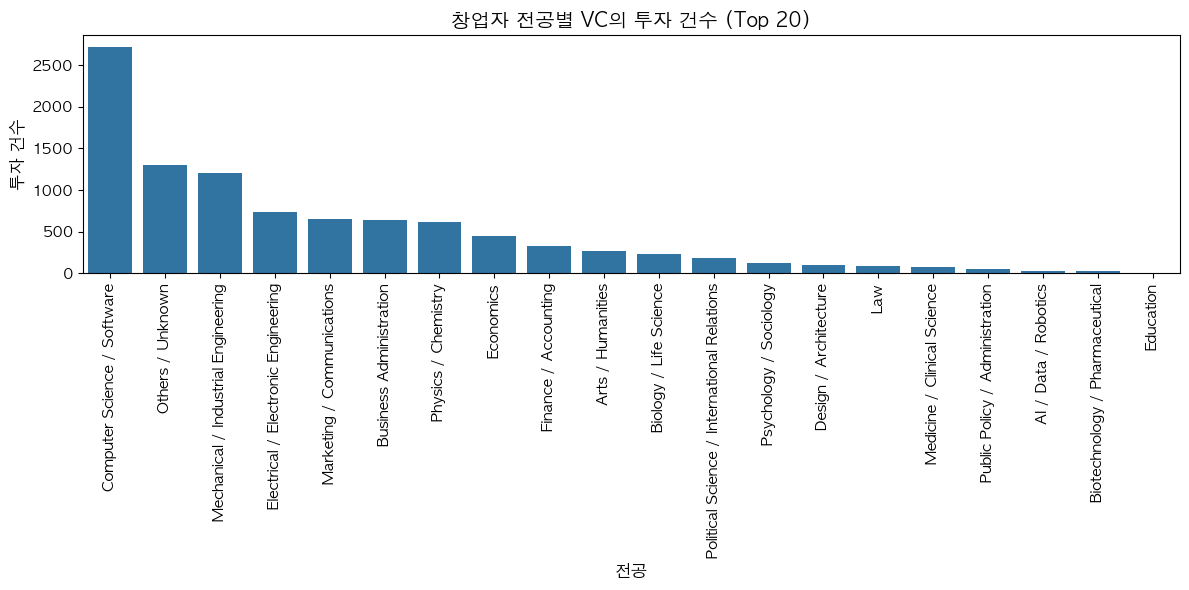

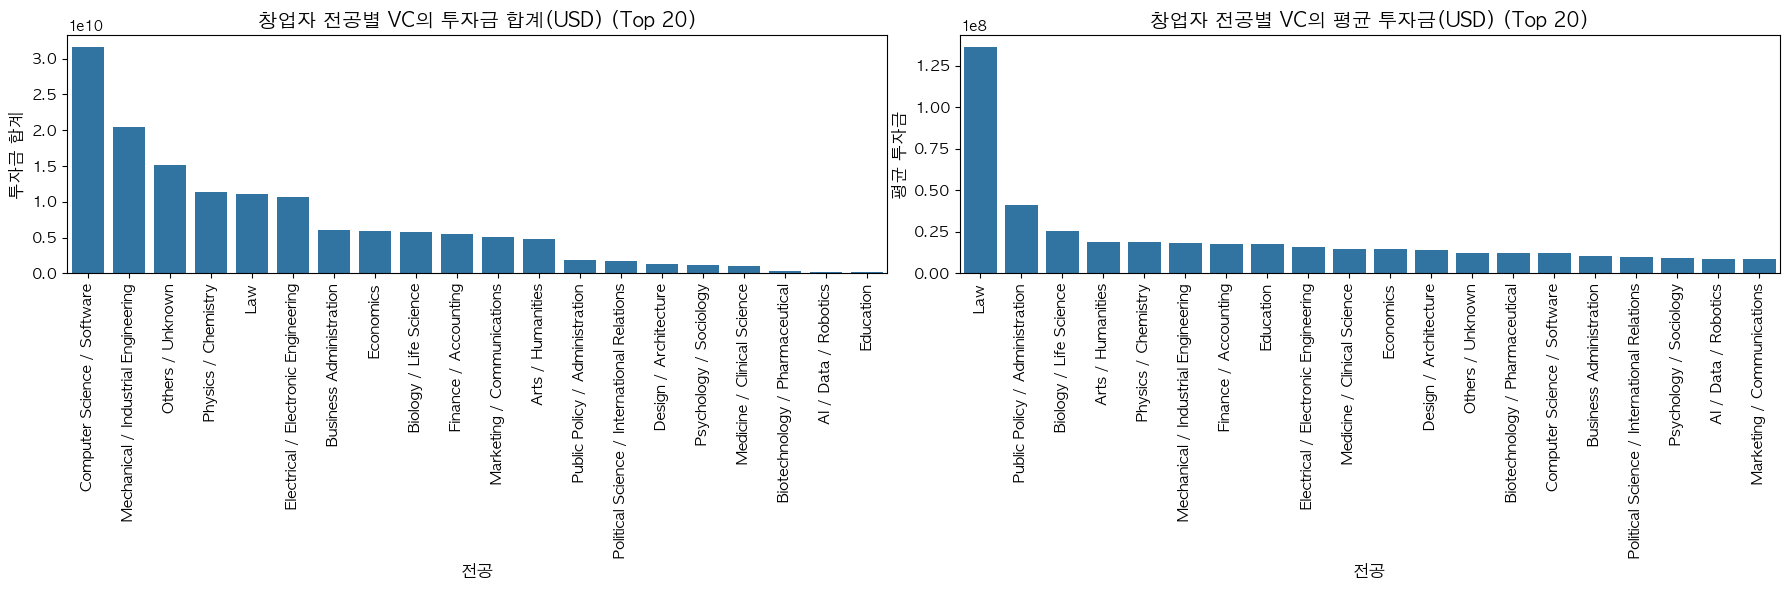

In [158]:
# 전공: cat_degrees_subject

# 데이터 정렬
subject_cnt_sorted = unique_founder_events['cat_degrees_subject'].value_counts(ascending=False).head(20)
subject_amount_sum_sorted = open_unique_founder_amount.groupby('cat_degrees_subject')['raised_amount_usd'].sum().sort_values(ascending=False).head(20)
subject_amount_mean_sorted = open_unique_founder_amount.groupby('cat_degrees_subject')['raised_amount_usd'].mean().sort_values(ascending=False).head(20)

# (1) 투자 건수 - 개별 그래프
plt.figure(figsize=(12, 6))
sns.countplot(data=unique_founder_events, x='cat_degrees_subject', order=subject_cnt_sorted.index)
plt.title("창업자 전공별 VC의 투자 건수 (Top 20)", fontsize=14)
plt.xlabel("전공", fontsize=12)
plt.ylabel("투자 건수", fontsize=12)
plt.xticks(rotation=90, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

# (2) 투자금 합계와 평균 - 함께
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 합계
sns.barplot(data=open_unique_founder_amount, x='cat_degrees_subject', y='raised_amount_usd', 
            order=subject_amount_sum_sorted.index, estimator=sum, errorbar=None, ax=axes[0])
axes[0].set_title("창업자 전공별 VC의 투자금 합계(USD) (Top 20)", fontsize=14)
axes[0].set_xlabel("전공", fontsize=12)
axes[0].set_ylabel("투자금 합계", fontsize=12)
axes[0].tick_params(axis='x', rotation=90, labelsize=11)
axes[0].tick_params(axis='y', labelsize=11)

# 평균
sns.barplot(data=open_unique_founder_amount, x='cat_degrees_subject', y='raised_amount_usd', 
            order=subject_amount_mean_sorted.index, errorbar=None, ax=axes[1])
axes[1].set_title("창업자 전공별 VC의 평균 투자금(USD) (Top 20)", fontsize=14)
axes[1].set_xlabel("전공", fontsize=12)
axes[1].set_ylabel("평균 투자금", fontsize=12)
axes[1].tick_params(axis='x', rotation=90, labelsize=11)
axes[1].tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()

In [159]:
unique_founder_events

investments_id  funding_round_id invested_c_id investor_cfp_id  \
0                   3                 3           c:5             f:4   
1                   4                 4           c:5             f:1   
2                   5                 4           c:5             f:5   
3                   6                 4           c:5             f:6   
4                   7                 4           c:5          f:3181   
...               ...               ...           ...             ...   
22794           61387             57877      c:181145          f:9913   
22795           61388             57879      c:285244         f:15039   
22796           61389             57879      c:285244          f:2019   
22797           61390             57880      c:285244         f:15039   
22798           61394             57903       c:10272           f:136   

        fr_c_id  funded_at funding_round_type funding_round_code  \
0           c:5        NaT           series-a                  a   
1           c:5        NaT           series-b                  b   
2           c:5        NaT           series-b                  b   
3           c:5        NaT           series-b                  b   
4           c:5        NaT           series-b                  b   
...         ...        ...                ...                ...   
22794  c:181145 2013-12-12           series-b                  b   
22795  c:285244        NaT           series-b                  b   
22796  c:285244        NaT           series-b                  b   
22797  c:285244        NaT           series-a                  a   
22798   c:10272 2013-12-12            venture       unattributed   

       raised_amount_usd  pre_money_valuation_usd  post_money_valuation_usd  \
0             12700000.0              115000000.0                       NaN   
1             27500000.0              525000000.0                       NaN   
2             27500000.0              525000000.0                       NaN   
3             27500000.0              525000000.0                       NaN   
4             27500000.0              525000000.0                       NaN   
...                  ...                      ...                       ...   
22794         25000000.0                      NaN                       NaN   
22795                NaN                      NaN                       NaN   
22796                NaN                      NaN                       NaN   
22797                NaN                      NaN                       NaN   
22798         30000000.0                      NaN                       NaN   

       participants  is_first_round  is_last_round  funded_year  \
0                 3               0              0          NaN   
1                 4               0              0          NaN   
2                 4               0              0          NaN   
3                 4               0              0          NaN   
4                 4               0              0          NaN   
...             ...             ...            ...          ...   
22794             3               1              0       2013.0   
22795             5               0              0          NaN   
22796             5               0              0          NaN   
22797             3               0              0          NaN   
22798             1               1              0       2013.0   

      funded_quarter cat_fr_type  num_fr_type  log_participants  \
0                NaT    series-a            2          1.386294   
1                NaT    series-b            3          1.609438   
2                NaT    series-b            3          1.609438   
3                NaT    series-b            3          1.609438   
4                NaT    series-b            3          1.609438   
...              ...         ...          ...               ...   
22794         2013Q4    series-b            3          1.386294   
22795            NaT   

##### 기업 규모: relationships(직원 수?), is_past(끝난 관계인지 여부: 1(과거)), sequence(우선순위?), cat_rel_title(직책)

In [173]:

unique_founder_events['relationships'].value_counts()

relationships
4      1773
3      1745
5      1586
2      1360
6      1300
7      1234
12     1087
8      1082
9       990
10      987
13      848
11      734
14      715
15      650
18      637
16      632
17      583
20      537
19      493
1       430
21      348
22      310
23      294
26      208
24      206
29      202
27      192
25      186
30      138
28      131
35      127
32      123
42      108
37       87
33       69
39       68
31       65
41       49
38       45
45       40
55       37
34       35
46       32
36       31
108      23
162      22
44       22
43       21
101      19
54       18
52       17
65       17
40       15
78       14
155      14
269      13
119      11
80        7
50        7
94        6
49        6
48        3
63        2
982       2
60        2
47        1
126       1
324       1
70        1
Name: count, dtype: int64

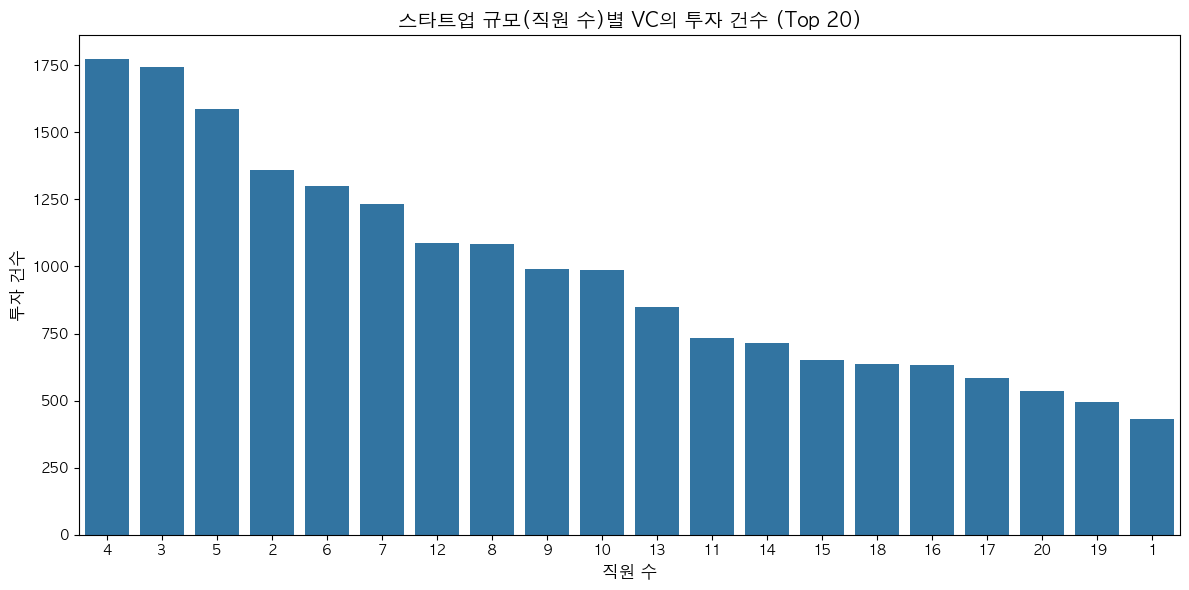

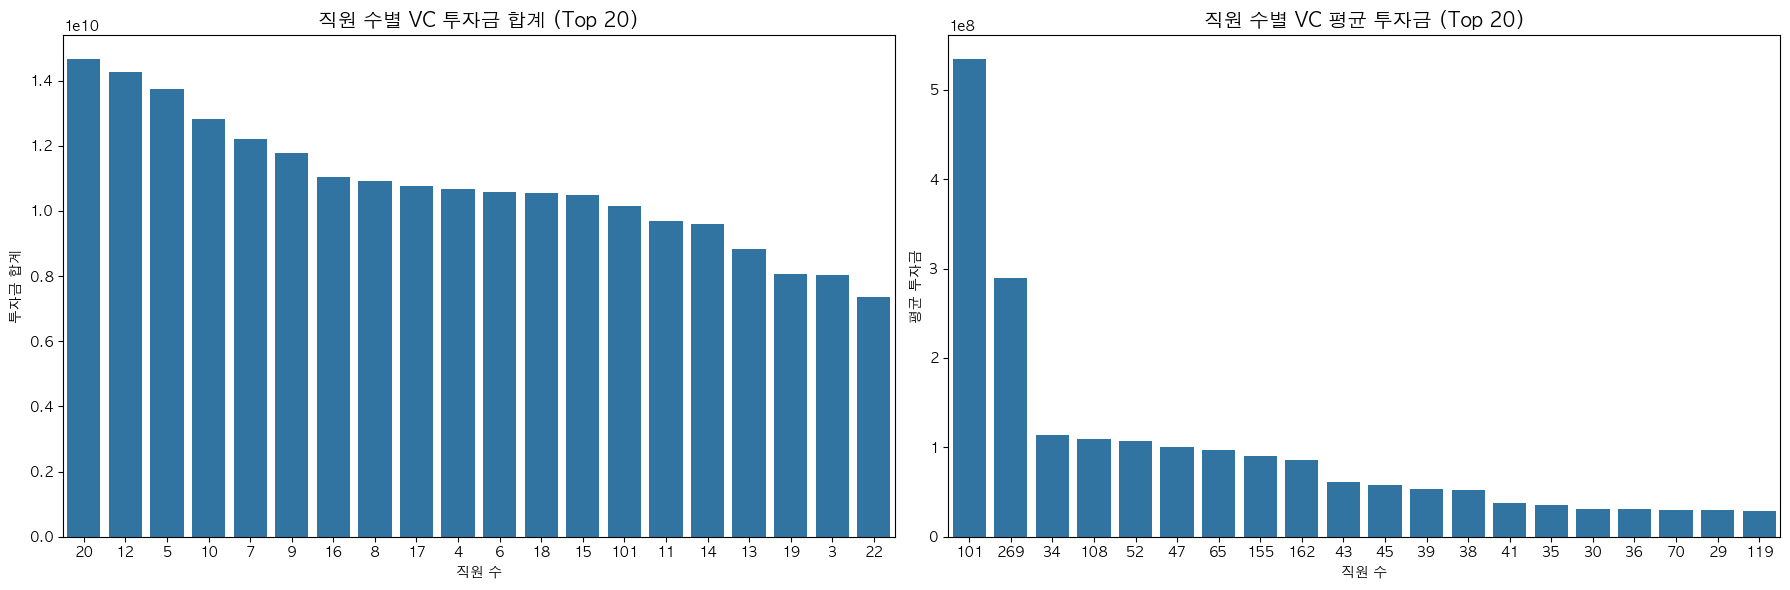

In [180]:
# 스타트업의 기업 규모에 따른 VC의 투자 패턴
# vc_invest_founder 테이블 사용
# 중복 투자 데이터 제거 테이블: unique_founder_events
# 중복 투자 데이터 제거 & 공개 투자금액 기준:open_unique_founder_amount

unique_founder_events
open_unique_founder_amount 

# 직원 수: relationships, 형변환
unique_founder_events['relationships'] = (
    pd.to_numeric(unique_founder_events['relationships'], errors='coerce')
)

open_unique_founder_amount['relationships'] = (
    pd.to_numeric(open_unique_founder_amount['relationships'], errors='coerce')
)


# 데이터 정렬
rel_cnt = (
    unique_founder_events['relationships']
    .value_counts()
    .sort_values(ascending=False)
    .head(20))

rel_amount_sum = (
    open_unique_founder_amount
    .groupby('relationships')['raised_amount_usd']
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

rel_amount_mean = (
    open_unique_founder_amount
    .groupby('relationships')['raised_amount_usd']
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

# (1) 투자 건수 - 개별 그래프
plt.figure(figsize=(12, 6))
sns.barplot(x=rel_cnt.index, y=rel_cnt.values, order=rel_cnt.index)
plt.title("스타트업 규모(직원 수)별 VC의 투자 건수 (Top 20)", fontsize=14)
plt.xlabel("직원 수", fontsize=12)
plt.ylabel("투자 건수", fontsize=12)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 합계
sns.barplot(x=rel_amount_sum.index, y=rel_amount_sum.values,order=rel_amount_sum.index, ax=axes[0])
axes[0].set_title("직원 수별 VC 투자금 합계 (Top 20)", fontsize=14)
axes[0].set_xlabel("직원 수")
axes[0].set_ylabel("투자금 합계")

# 평균
sns.barplot(x=rel_amount_mean.index, y=rel_amount_mean.values,order=rel_amount_mean.index, ax=axes[1])
axes[1].set_title("직원 수별 VC 평균 투자금 (Top 20)", fontsize=14)
axes[1].set_xlabel("직원 수")
axes[1].set_ylabel("평균 투자금")

plt.tight_layout()
plt.show()

##### 스타트업의 기업 규모별 VC의 투자 패턴

In [ ]:
FO_invest_founder

investments_id  funding_round_id invested_c_id investor_cfp_id  \
0                    1                 1           c:4             f:1   
1                    1                 1           c:4             f:1   
2                    1                 1           c:4             f:1   
3                    1                 1           c:4             f:1   
4                    1                 1           c:4             f:1   
...                ...               ...           ...             ...   
763408           61402             57942       c:70841         f:15098   
763409           61403             57948      c:211890          f:2101   
763410           61403             57948      c:211890          f:2101   
763411           61403             57948      c:211890          f:2101   
763412           61403             57948      c:211890          f:2101   

         fr_c_id  funded_at funding_round_type  raised_amount_usd  \
0            c:4 2006-12-01           series-b          8500000.0   
1            c:4 2006-12-01           series-b          8500000.0   
2            c:4 2006-12-01           series-b          8500000.0   
3            c:4 2006-12-01           series-b          8500000.0   
4            c:4 2006-12-01           series-b          8500000.0   
...          ...        ...                ...                ...   
763408   c:70841 2013-12-12            venture                NaN   
763409  c:211890 2013-12-12           series-a          3000000.0   
763410  c:211890 2013-12-12           series-a          3000000.0   
763411  c:211890 2013-12-12           series-a          3000000.0   
763412  c:211890 2013-12-12           series-a          3000000.0   

        pre_money_valuation_usd  post_money_valuation_usd  participants  \
0                           NaN                       NaN             2   
1                           NaN                       NaN             2   
2                           NaN                       NaN             2   
3                           NaN                       NaN             2   
4                           NaN                       NaN             2   
...                         ...                       ...           ...   
763408                      NaN                       NaN             1   
763409                      NaN                       NaN             1   
763410                      NaN                       NaN             1   
763411                      NaN                       NaN             1   
763412                      NaN                       NaN             1   

        is_first_round  is_last_round  funded_year funded_quarter cat_fr_type  \
0                    0              0       2006.0         2006Q4    series-b   
1                    0              0       2006.0         2006Q4    series-b   
2                    0              0       2006.0         2006Q4    series-b   
3                    0              0       2006.0         2006Q4    series-b   
4                    0              0       2006.0         2006Q4    series-b   
...                ...            ...          ...            ...         ...   
763408               1              1       2013.0         2013Q4        seed   
763409               1              1       2013.0         2013Q4    series-a   
763410               1              1       2013.0         2013Q4    series-a   
763411               1              1       2013.0         2013Q4    series-a   
763412               1              1       2013.0         2013Q4    series-a   

        num_fr_type  log_participants  is_fr_raised_private objects_cfpr_id  \
0                 2          1.098612                     0             c:4   
1                 2          1.098612                     0             c:4   
2                 2          1.098612                     0             c:4   
3                 2          1.098612                     0             c:4   
4                 2  

##### 스타트업 규모별 VC 투자 패턴

In [214]:
# 스타트업의 기업 규모별 VC의 투자 패턴 cat_obj_status(기업 상태), sequence, cat_rel_title(직위), is_past, funding_rounds(지금까지 받은 투자 라운드 수), funding_total_usd(총 투자 받은 금액))

# 스타트업 직원 구성에 따른 VC의 투자 패턴 분석
# 직원 구성을 보려면 원본 FO_invest_founder 테이블 사용(VC 데이터만 사용)
# 투자 건수 및 투자금 분포를 보려면 

# 직원 구성 테이블 만들기
role_matrix = (
    FO_invest_founder
        .groupby(['investments_id', 'cat_rel_title'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
)

# 컬럼명 공백 제거 (만약 있는 경우)
role_matrix.columns = [c.replace(" ", "_") for c in role_matrix.columns]

org_profile = role_matrix.copy()

role_cols = [c for c in org_profile.columns if c != 'investments_id']
org_profile['total_staff'] = org_profile[role_cols].sum(axis=1)

# 투자 건수 결합(unique_founder_events)
investment_info = (
    unique_founder_events
        .groupby('investments_id')
        .size()
        .reset_index(name='invest_count')
)

org_profile = org_profile.merge(investment_info, on='investments_id', how='left')

# 투자금 결합(open_unique_founder_amount)
amount_info = (
    open_unique_founder_amount[['investments_id', 'raised_amount_usd']]
        .groupby('investments_id')
        .sum()
        .reset_index()
)

org_profile = org_profile.merge(amount_info, on='investments_id', how='left')
org_profile['raised_amount_usd'] = org_profile['raised_amount_usd'].fillna(0)


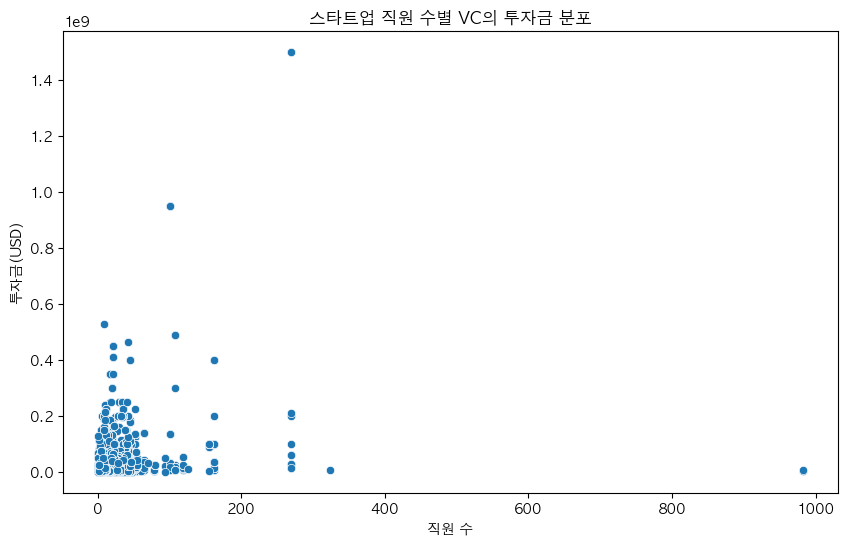

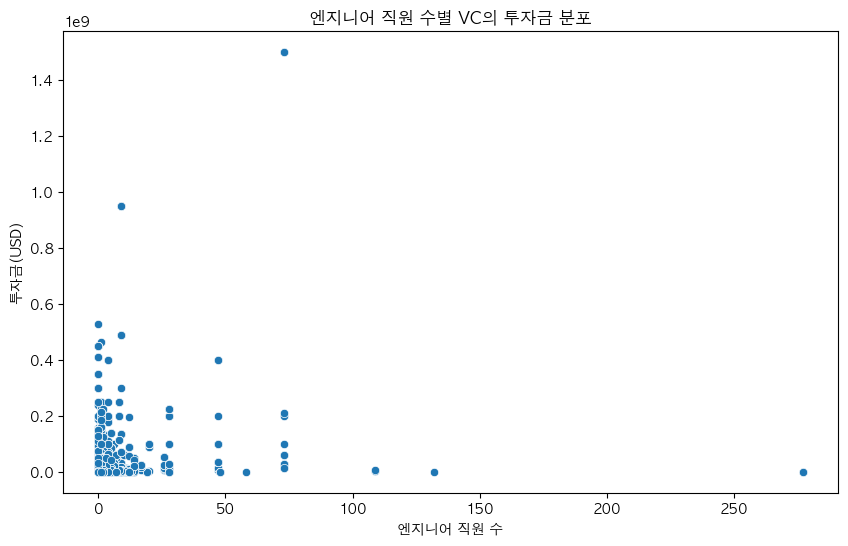

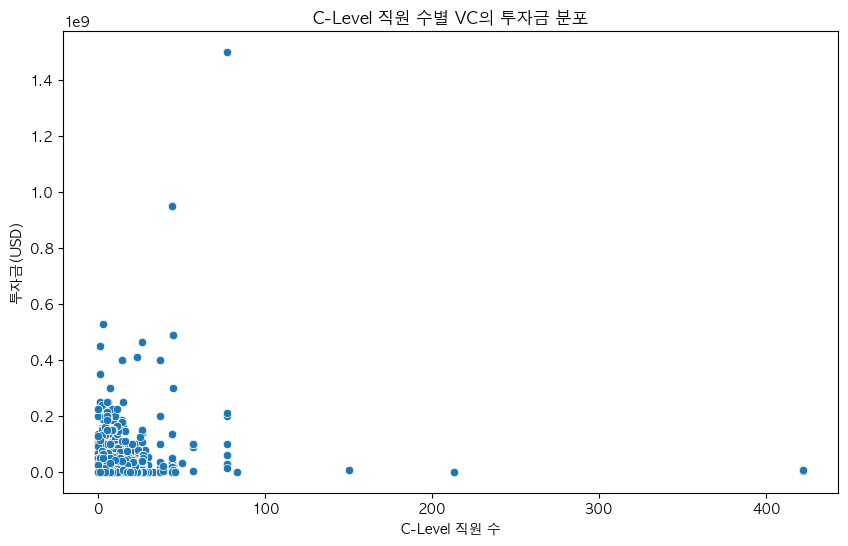

In [217]:
# 스타트업 직원 수별 VC의 투자금 분포
plt.figure(figsize=(10,6))
sns.scatterplot(data=open_unique_founder_amount, x='relationships', y='raised_amount_usd')
plt.title("스타트업 직원 수별 VC의 투자금 분포")
plt.xlabel("직원 수")
plt.ylabel("투자금(USD)")
plt.show()

# 엔지니어 직원 수별 VC의 투자금 분포
plt.figure(figsize=(10,6))
sns.scatterplot(data=org_profile, x='Engineering', y='raised_amount_usd')
plt.title("엔지니어 직원 수별 VC의 투자금 분포")
plt.xlabel("엔지니어 직원 수")
plt.ylabel("투자금(USD)")
plt.show()


# C-Level 직원 수별 VC의 투자금 분포
plt.figure(figsize=(10,6))
sns.scatterplot(data=org_profile, x='C-Level', y='raised_amount_usd')
plt.title("C-Level 직원 수별 VC의 투자금 분포")
plt.xlabel("C-Level 직원 수")
plt.ylabel("투자금(USD)")
plt.show()


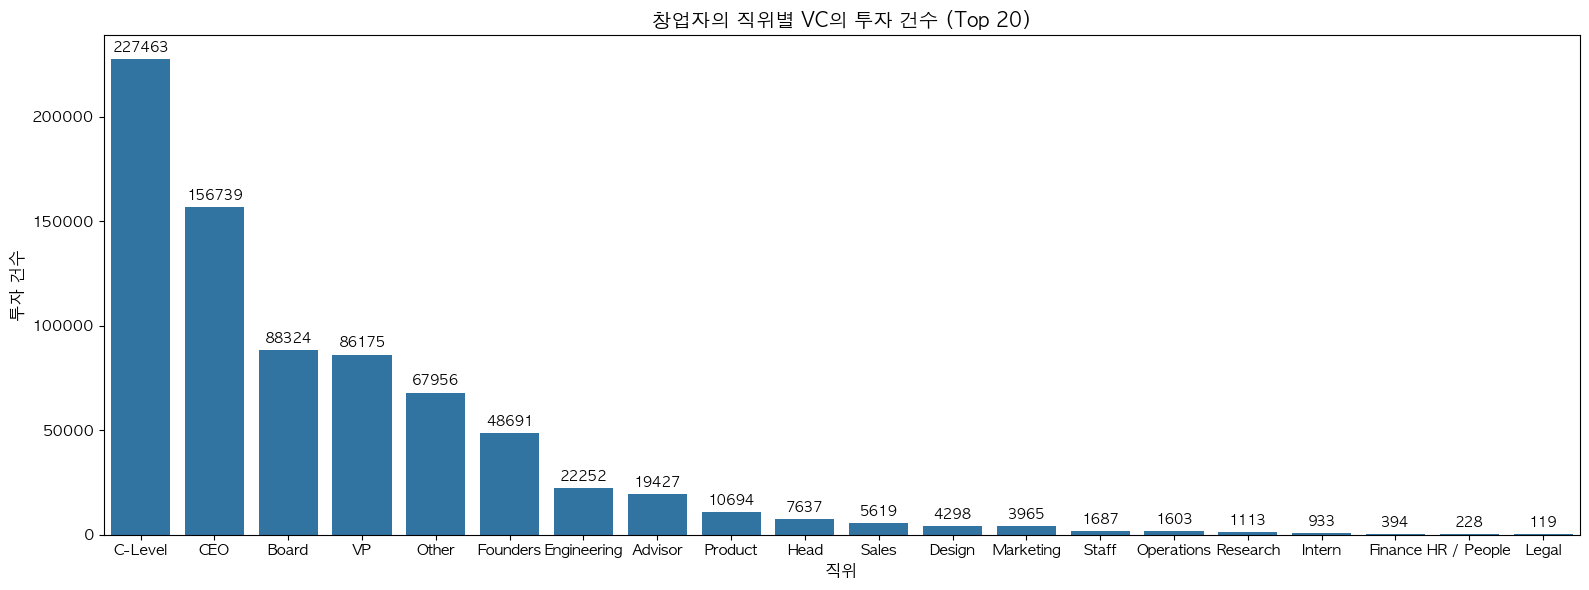

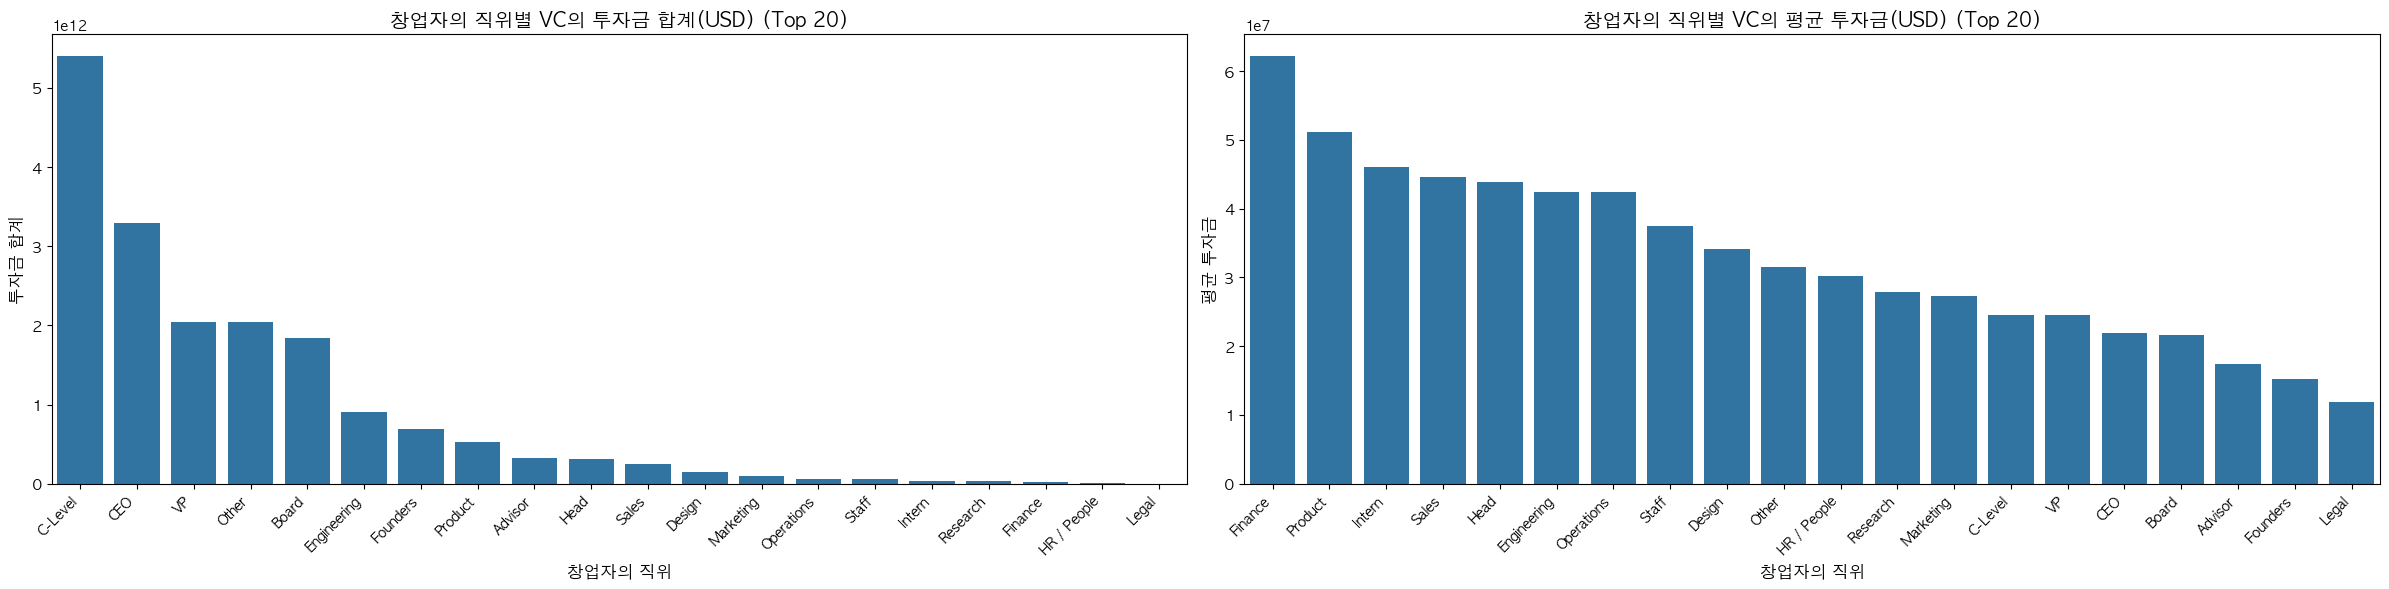

In [ ]:
# 스타트업의 기업 규모별 VC의 투자 패턴: sequence, cat_rel_title(직위), is_past
vc_invest_founder

# =====================================
# VC는 주로 어떤 규모의 스타트업에 투자할까?
# =====================================
# cat_rel_title(창업자의 직위)

# 데이터 정렬 (상위 20개)
cat_rel_title_cnt_sorted = FO_invest_founder['cat_rel_title'].value_counts(ascending=False).head(20)
cat_rel_title_sum_sorted = open_founder_amount.groupby('cat_rel_title')['raised_amount_usd'].sum().sort_values(ascending=False).head(20)
cat_rel_title_mean_sorted = open_founder_amount.groupby('cat_rel_title')['raised_amount_usd'].mean().sort_values(ascending=False).head(20)

# (1) 투자 건수 - 개별 그래프
plt.figure(figsize=(16, 6))
ax = sns.countplot(data=FO_invest_founder, x='cat_rel_title', order=cat_rel_title_cnt_sorted.index)
plt.title("창업자의 직위별 VC의 투자 건수 (Top 20)", fontsize=14)
plt.xlabel("직위", fontsize=12)
plt.ylabel("투자 건수", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
for container in ax.containers:
    ax.bar_label(container, padding=3)
plt.tight_layout()
plt.show()

# (2) 투자금 합계와 평균 - 함께
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# ---------------------------------
# (1) 합계
# ---------------------------------
sns.barplot(
    data=open_founder_amount,
    x='cat_rel_title',
    y='raised_amount_usd',
    order=cat_rel_title_sum_sorted.index,
    estimator=sum,
    errorbar=None,
    ax=axes[0]
)
axes[0].set_title("창업자의 직위별 VC의 투자금 합계(USD) (Top 20)", fontsize=14)
axes[0].set_xlabel("창업자의 직위", fontsize=12)
axes[0].set_ylabel("투자금 합계", fontsize=12)

# 핵심: x축 글자 회전 + 정렬 + 여백 조정
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', labelsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')

# ---------------------------------
# (2) 평균
# ---------------------------------
sns.barplot(
    data=open_founder_amount,
    x='cat_rel_title',
    y='raised_amount_usd',
    order=cat_rel_title_mean_sorted.index,
    errorbar=None,
    ax=axes[1]
)
axes[1].set_title("창업자의 직위별 VC의 평균 투자금(USD) (Top 20)", fontsize=14)
axes[1].set_xlabel("창업자의 직위", fontsize=12)
axes[1].set_ylabel("평균 투자금", fontsize=12)

# 동일한 회전 적용
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=11)
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right')

# ---------------------------------
# 전체 여백 조정
# ---------------------------------
plt.subplots_adjust(bottom=0.25, wspace=0.15)  # 하단 여백 증가 & subplot 간격
plt.tight_layout()
plt.show()

### 투자 라운드 - 엑싯 성공률
- M&A
- IPO

In [ ]:
#########################
# 변경자: 수아
# 변경일자: 25.12.11
# 변경
# 내용: 1. 투자 라운드별 엑싯 성공률(M&A) EDA
##########################

# ============================================================
# VC가 어떤 투자 라운드의 기업에 투자했을 때 인수합병 성공률이 높을까?
# ============================================================
'invested_c_id' # 그룹화 기준
'investor_cfp_id'
'cat_fr_type', 'funding_round_type' # 투자 라운드 타입
'num_fr_type'
'is_first_round'
'is_last_round'
'participants'
'is_fr_raised_private' # 투자 조달금 비공개 여부(1: 비공개, 0: 공개)
'entity_type' # FinancialOrg 필터링
'status', 'cat_obj_status' # acquired
'first_funding_at'
'last_funding_at'
'funding_rounds' # 지금까지 받은 투자 수
'funding_total_usd'
'relationships'

vc_invest_fr_acq

# 투자자 id: f 한정
# 투자 라운드별 인수합병 기업 분포
# invested_c_id = fr_c_id
# 투자 받은 회사별 투자 라운드 분포
# invested_c_id 기준 그룹화
# cat_fr_type 카운트 분포 확인

vc_invest_fr_acq

investments_id  funding_round_id invested_c_id investor_cfp_id  \
0                   1                 1           c:4             f:1   
1                   2                 1           c:4             f:2   
2                   3                 3           c:5             f:4   
3                   4                 4           c:5             f:1   
4                   5                 4           c:5             f:5   
...               ...               ...           ...             ...   
81138           80898             57882      c:285244        p:267312   
81139           80899             57912       c:60389        p:268570   
81140           80900             57929      c:286183           p:365   
81141           80901             57929      c:286183        p:176466   
81142           80902             57929      c:286183        p:268577   

        fr_c_id  funded_at funding_round_type  raised_amount_usd  \
0           c:4 2006-12-01           series-b          8500000.0   
1           c:4 2006-12-01           series-b          8500000.0   
2           c:5        NaT           series-a         12700000.0   
3           c:5        NaT           series-b         27500000.0   
4           c:5        NaT           series-b         27500000.0   
...         ...        ...                ...                ...   
81138  c:285244        NaT              angel                NaN   
81139   c:60389        NaT          series-c+                NaN   
81140  c:286183 2013-12-12              angel           225000.0   
81141  c:286183 2013-12-12              angel           225000.0   
81142  c:286183 2013-12-12              angel           225000.0   

       pre_money_valuation_usd  post_money_valuation_usd  participants  \
0                          NaN                       NaN             2   
1                          NaN                       NaN             2   
2                  115000000.0                       NaN             3   
3                  525000000.0                       NaN             4   
4                  525000000.0                       NaN             4   
...                        ...                       ...           ...   
81138                      NaN                       NaN             3   
81139                      NaN                       NaN             1   
81140                      NaN                       NaN             3   
81141                      NaN                       NaN             3   
81142                      NaN                       NaN             3   

       is_first_round  is_last_round  funded_year funded_quarter cat_fr_type  \
0                   0              0       2006.0         2006Q4    series-b   
1                   0              0       2006.0         2006Q4    series-b   
2                   0              0          NaN            NaT    series-a   
3                   0              0          NaN            NaT    series-b   
4                   0              0          NaN            NaT    series-b   
...               ...            ...          ...            ...         ...   
81138               0              1          NaN            NaT        seed   
81139               1              1          NaN            NaT   series-c+   
81140               1              1       2013.0         2013Q4        seed   
81141               1              1       2013.0         2013Q4        seed   
81142               1              1       2013.0         2013Q4        seed   

       num_fr_type  log_participants  is_fr_raised_private objects_cfpr_id  \
0                2          1.098612                     0             c:4   
1                2          1.098612                     0             c:4   
2                1          1.386294                     0             c:5   
3                2          1.609438                     0             c:5   
4                2          1.609438                     0             c:

In [ ]:
vc_invest_fr_acq['cat_fr_type'].value_counts()

cat_fr_type
seed              32519
series-a          20304
series-c+         13758
series-b          12186
other              1451
private-equity      876
post-ipo             49
Name: count, dtype: int64

In [ ]:
# 투자자 id: f 한정
# 투자 라운드별 인수합병 기업 분포
# invested_c_id = fr_c_id
# 투자 받은 회사별 투자 라운드 분포
# invested_c_id 기준 그룹화
# cat_fr_type 카운트 분포 확인

# investor_cfp_id: FinancialOrg 필터링 변수 선언
FO_invest_fr_acq = vc_invest_fr_acq[vc_invest_fr_acq['investor_cfp_id'].str.startswith('f:')]
FO_invest_fr_acq


investments_id  funding_round_id invested_c_id investor_cfp_id  \
0                   1                 1           c:4             f:1   
1                   2                 1           c:4             f:2   
2                   3                 3           c:5             f:4   
3                   4                 4           c:5             f:1   
4                   5                 4           c:5             f:5   
...               ...               ...           ...             ...   
61581           61399             57926       c:15847           f:173   
61582           61400             57926       c:15847          f:1290   
61583           61401             57926       c:15847            f:73   
61584           61402             57942       c:70841         f:15098   
61585           61403             57948      c:211890          f:2101   

        fr_c_id  funded_at funding_round_type  raised_amount_usd  \
0           c:4 2006-12-01           series-b          8500000.0   
1           c:4 2006-12-01           series-b          8500000.0   
2           c:5        NaT           series-a         12700000.0   
3           c:5        NaT           series-b         27500000.0   
4           c:5        NaT           series-b         27500000.0   
...         ...        ...                ...                ...   
61581   c:15847 2013-12-12            venture         15000000.0   
61582   c:15847 2013-12-12            venture         15000000.0   
61583   c:15847 2013-12-12            venture         15000000.0   
61584   c:70841 2013-12-12            venture                NaN   
61585  c:211890 2013-12-12           series-a          3000000.0   

       pre_money_valuation_usd  post_money_valuation_usd  participants  \
0                          NaN                       NaN             2   
1                          NaN                       NaN             2   
2                  115000000.0                       NaN             3   
3                  525000000.0                       NaN             4   
4                  525000000.0                       NaN             4   
...                        ...                       ...           ...   
61581                      NaN                       NaN             4   
61582                      NaN                       NaN             4   
61583                      NaN                       NaN             4   
61584                      NaN                       NaN             1   
61585                      NaN                       NaN             1   

       is_first_round  is_last_round  funded_year funded_quarter cat_fr_type  \
0                   0              0       2006.0         2006Q4    series-b   
1                   0              0       2006.0         2006Q4    series-b   
2                   0              0          NaN            NaT    series-a   
3                   0              0          NaN            NaT    series-b   
4                   0              0          NaN            NaT    series-b   
...               ...            ...          ...            ...         ...   
61581               1              0       2013.0         2013Q4        seed   
61582               1              0       2013.0         2013Q4        seed   
61583               1              0       2013.0         2013Q4        seed   
61584               1              1       2013.0         2013Q4        seed   
61585               1              1       2013.0         2013Q4    series-a   

       num_fr_type  log_participants  is_fr_raised_private objects_cfpr_id  \
0                2          1.098612                     0             c:4   
1                2          1.098612                     0             c:4   
2                1          1.386294                     0             c:5   
3                2          1.609438                     0             c:5   
4                2          1.609438                     0             c:

In [ ]:
# 중복되는 투자 이벤트 개수 확인
vc_invest_fr_ipo['investments_id'].duplicated().sum()
vc_invest_fr_acq['investments_id'].duplicated().sum()

np.int64(241)